In [1]:
pip install medmnist timm torch torchvision -q

Note: you may need to restart the kernel to use updated packages.


In [80]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from timm import create_model
import torch.nn as nn
import torch.optim as optim
import os
import requests
import zipfile
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import medmnist

from torch.utils.data import Subset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.linalg import inv
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import TensorDataset
from torch.cuda.amp import autocast

from torchvision import transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from PIL import Image

from transformers import ViTModel, ViTImageProcessor

import timm
from timm import create_model

from torch_geometric.nn import LabelPropagation
from torch_geometric.utils import dense_to_sparse

import numpy as np
import pandas as pd

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import networkx as nx
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data

import os
import requests
import zipfile
from tqdm import tqdm
from collections import defaultdict, Counter
import random
import matplotlib.pyplot as plt
from torch.linalg import inv
import seaborn as sns
import medmnist


2025-01-07 12:30:08.367320: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 12:30:08.376277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-07 12:30:08.385757: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-07 12:30:08.388572: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 12:30:08.396654: I tensorflow/core/platform/cpu_feature_guar

In [4]:
torch.cuda.empty_cache()

In [5]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [19]:
#lass NumpyDataset(Dataset):
#   def __init__(self, images_path, labels_path, transform=None):
#       self.images = np.load(images_path)
#       self.labels = np.load(labels_path)
#       self.transform = transform
#
#   def __len__(self):
#       return len(self.images)
#
#   def __getitem__(self, idx):
#       image = self.images[idx]
#       label = self.labels[idx]
#       
#       image = (image * 255).astype(np.uint8)
#       label = int(label) # int label 1d
#
#       # CHW
#       image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
#       if self.transform:
#           image = self.transform(image)
#       
#       return image, label
    

class NumpyDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = np.load(images_path)
        self.labels = np.load(labels_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = (image * 255).astype(np.uint8)

        if len(image.shape) == 2:  # Grayscale image
            #age = np.expand_dims(image, axis=0)
            image = np.stack([image] * 3, axis=0)
        else:
            image = image.transpose(2, 0, 1)

        image = torch.tensor(image, dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)

        return image,  int(label.item())


In [53]:
path = '/home/dime/Desktop/Pre-thesis/data/pneumoniamnist_224'

In [21]:
from collections import Counter

def compute_class_counts(labels_path):
    labels = np.load(labels_path).flatten()  
    return dict(Counter(labels))  

In [22]:
img_size=224

batch_size = 32

epochs = 30

num_epochs = 30

learning_rate = 0.001

num_classes = 2

In [31]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0), antialias=True),  # Explicit antialias
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [24]:
def load_datasets(img_size=img_size, batch_size=batch_size):
    train_dataset = NumpyDataset(os.path.join(path, 'train_images.npy'), os.path.join(path, 'train_labels.npy'), transform)
    val_dataset = NumpyDataset(os.path.join(path, 'val_images.npy'), os.path.join(path, 'val_labels.npy'), transform)
    test_dataset = NumpyDataset(os.path.join(path, 'test_images.npy'), os.path.join(path, 'test_labels.npy'), transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [25]:
train_class_counts = compute_class_counts(os.path.join(path, 'train_labels.npy'))
val_class_counts = compute_class_counts(os.path.join(path, 'val_labels.npy'))
test_class_counts = compute_class_counts(os.path.join(path, 'test_labels.npy'))

print('Train class counts:', train_class_counts)
print('Val class counts:', val_class_counts)
print('Test class counts:', test_class_counts)

Train class counts: {1: 3494, 0: 1214}
Val class counts: {1: 389, 0: 135}
Test class counts: {1: 390, 0: 234}


In [41]:
import torch.nn as nn
from timm import create_model

class VGG16(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.model = create_model('vgg16', pretrained=True, num_classes=1000)

        for param in self.model.parameters():
            param.requires_grad = False

        self.model.reset_classifier(num_classes=num_classes)

        for param in self.model.get_classifier().parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.model(x)

model = VGG16(num_classes=2)

for name, param in model.model.named_parameters():
    print(name, param.requires_grad)

features.0.weight False
features.0.bias False
features.2.weight False
features.2.bias False
features.5.weight False
features.5.bias False
features.7.weight False
features.7.bias False
features.10.weight False
features.10.bias False
features.12.weight False
features.12.bias False
features.14.weight False
features.14.bias False
features.17.weight False
features.17.bias False
features.19.weight False
features.19.bias False
features.21.weight False
features.21.bias False
features.24.weight False
features.24.bias False
features.26.weight False
features.26.bias False
features.28.weight False
features.28.bias False
pre_logits.fc1.weight False
pre_logits.fc1.bias False
pre_logits.fc2.weight False
pre_logits.fc2.bias False
head.fc.weight True
head.fc.bias True


In [27]:
def plot_metrics(metrics_log):
    epochs = range(1, len(metrics_log["train_loss"]) + 1)

    # Plot loss
    plt.figure()
    plt.plot(epochs, metrics_log["train_loss"], label="Train Loss")
    plt.plot(epochs, metrics_log["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, metrics_log["train_accuracy"], label="Train Accuracy")
    plt.plot(epochs, metrics_log["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.legend()
    plt.show()

    # Plot F1 score
    plt.figure()
    plt.plot(epochs, metrics_log["train_f1"], label="Train F1 Score")
    plt.plot(epochs, metrics_log["val_f1"], label="Validation F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.title("F1 Score vs Epochs")
    plt.legend()
    plt.show()

In [47]:
def train_model(
    model, train_loader, val_loader, device, num_epochs=num_epochs, lr=learning_rate, patience=5, accumulation_steps=4
):

    metrics_log = {
        "train_loss": [],
        "train_accuracy": [],
        "train_f1": [],
        "val_loss": [],
        "val_accuracy": [],
        "val_f1": []
    }

    criterion = nn.CrossEntropyLoss()
    #imizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = torch.cuda.amp.GradScaler()

    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_labels, all_preds = [], []

        for step, (images, labels) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}")):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad(set_to_none=True)  # memory fragmentation
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels) / accumulation_steps  

            scaler.scale(loss).backward()

            if (step + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            running_loss += loss.item() * accumulation_steps  
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        train_accuracy = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        train_loss = running_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        val_labels, val_preds = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validating"):
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(predicted.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        val_loss /= len(val_loader)

        metrics_log["train_loss"].append(train_loss)
        metrics_log["train_accuracy"].append(train_accuracy)
        metrics_log["train_f1"].append(train_f1)
        metrics_log["val_loss"].append(val_loss)
        metrics_log["val_accuracy"].append(val_accuracy)
        metrics_log["val_f1"].append(val_f1)

        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}]:")
        print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "vgg_bstl.pth")  
            print("Validation loss improved. Model saved.")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epochs.")

        if patience_counter >= patience:
            print("Early stopping")
            break

    print(f"Final Train Loss: {metrics_log['train_loss'][-1]:.4f}")
    print(f"Final Train Accuracy: {metrics_log['train_accuracy'][-1]:.4f}")
    print(f"Final Train F1: {metrics_log['train_f1'][-1]:.4f}")
    print(f"Final Val Loss: {metrics_log['val_loss'][-1]:.4f}")
    print(f"Final Val Accuracy: {metrics_log['val_accuracy'][-1]:.4f}")
    print(f"Final Val F1: {metrics_log['val_f1'][-1]:.4f}")

    plot_metrics(metrics_log)
    return metrics_log



Validating: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


Epoch [1/30]:
  Train Loss: 0.5723, Accuracy: 0.7096, F1: 0.6443
  Val Loss: 0.5866, Accuracy: 0.7462, F1: 0.6481
Validation loss improved. Model saved.


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


Epoch [2/30]:
  Train Loss: 0.5363, Accuracy: 0.7810, F1: 0.7283
  Val Loss: 0.5405, Accuracy: 0.7939, F1: 0.7675
Validation loss improved. Model saved.


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]


Epoch [3/30]:
  Train Loss: 0.5387, Accuracy: 0.7944, F1: 0.7610
  Val Loss: 0.5469, Accuracy: 0.7634, F1: 0.6989
No improvement in validation loss for 1 epochs.


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


Epoch [4/30]:
  Train Loss: 0.5110, Accuracy: 0.7893, F1: 0.7434
  Val Loss: 0.5133, Accuracy: 0.7786, F1: 0.7314
Validation loss improved. Model saved.


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


Epoch [5/30]:
  Train Loss: 0.4841, Accuracy: 0.7993, F1: 0.7642
  Val Loss: 0.5039, Accuracy: 0.8168, F1: 0.7953
Validation loss improved. Model saved.


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


Epoch [6/30]:
  Train Loss: 0.4700, Accuracy: 0.8067, F1: 0.7754
  Val Loss: 0.5115, Accuracy: 0.7863, F1: 0.7469
No improvement in validation loss for 1 epochs.


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


Epoch [7/30]:
  Train Loss: 0.4854, Accuracy: 0.7984, F1: 0.7598
  Val Loss: 0.5300, Accuracy: 0.7824, F1: 0.7409
No improvement in validation loss for 2 epochs.


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


Epoch [8/30]:
  Train Loss: 0.4703, Accuracy: 0.7995, F1: 0.7616
  Val Loss: 0.4951, Accuracy: 0.7939, F1: 0.7574
Validation loss improved. Model saved.


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]


Epoch [9/30]:
  Train Loss: 0.4876, Accuracy: 0.7997, F1: 0.7647
  Val Loss: 0.5013, Accuracy: 0.8015, F1: 0.7622
No improvement in validation loss for 1 epochs.


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]


Epoch [10/30]:
  Train Loss: 0.4694, Accuracy: 0.8006, F1: 0.7650
  Val Loss: 0.5028, Accuracy: 0.7977, F1: 0.7646
No improvement in validation loss for 2 epochs.


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


Epoch [11/30]:
  Train Loss: 0.4643, Accuracy: 0.8061, F1: 0.7703
  Val Loss: 0.5127, Accuracy: 0.7996, F1: 0.7699
No improvement in validation loss for 3 epochs.


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


Epoch [12/30]:
  Train Loss: 0.4938, Accuracy: 0.8056, F1: 0.7736
  Val Loss: 0.5163, Accuracy: 0.7882, F1: 0.7499
No improvement in validation loss for 4 epochs.


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]

Epoch [13/30]:
  Train Loss: 0.4619, Accuracy: 0.8061, F1: 0.7735
  Val Loss: 0.5117, Accuracy: 0.7958, F1: 0.7546
No improvement in validation loss for 5 epochs.
Early stopping
Final Train Loss: 0.4619
Final Train Accuracy: 0.8061
Final Train F1: 0.7735
Final Val Loss: 0.5117
Final Val Accuracy: 0.7958
Final Val F1: 0.7546


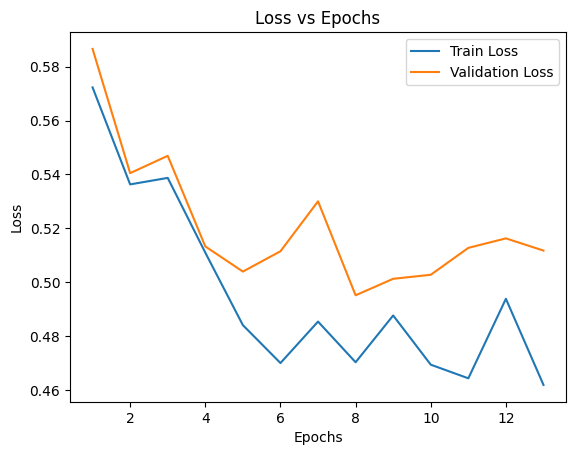

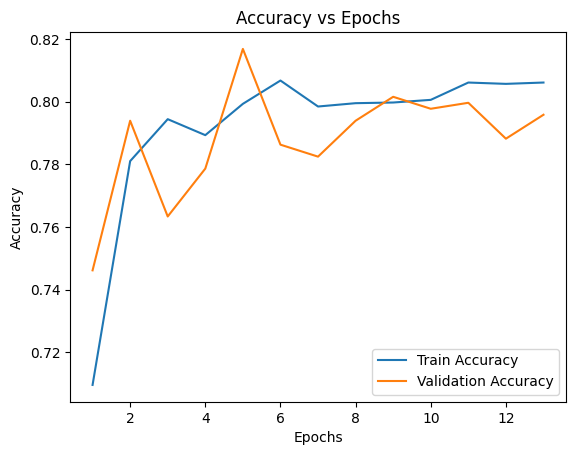

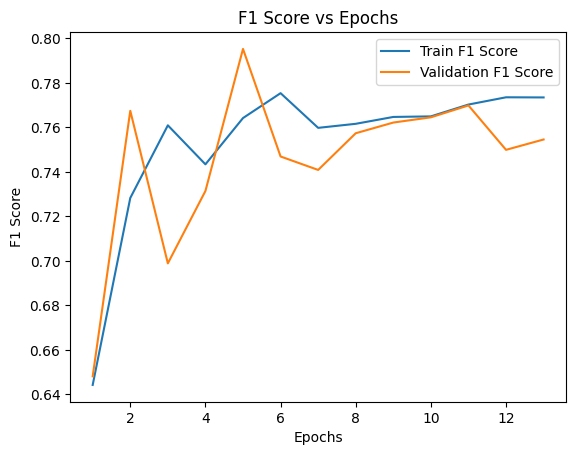

In [48]:
if __name__ == "__main__":
    train_loader, val_loader, test_loader = load_datasets(batch_size, img_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VGG16(num_classes=num_classes)

    train_model(model, train_loader, val_loader, device, num_epochs, learning_rate)

In [49]:
#save model 
path = '/home/dime/Desktop/Pre-thesis'
torch.save(model.state_dict(), os.path.join(path, 'vvgg_full_pneumonia.pth'))

## Random shuffle subset

In [70]:
# added shuffle for train
# count as well the amount of data 
percentage =10

path = '/home/dime/Desktop/Pre-thesis/data/pneumoniamnist_224'


def subset_dataset_percentage(dataset, labels_path, percentage=percentage, seed=42):
    random.seed(seed)
    labels = np.load(labels_path).flatten()
    class_indices = defaultdict(list)

    for idx, label in enumerate(labels):
        class_indices[label].append(idx)
    
    subset_indices = []
    for indices in class_indices.values():
        subset_size = max(1, int(len(indices) * (percentage / 100.0)))
        subset_indices.extend(random.sample(indices, subset_size))
    
    return Subset(dataset, subset_indices)

def load_data_subset(batch_size=batch_size, img_size=img_size, percentage=percentage):
    train_dataset = NumpyDataset(os.path.join(path, 'train_images.npy'), os.path.join(path, 'train_labels.npy'), transform)
    val_dataset = NumpyDataset(os.path.join(path, 'val_images.npy'), os.path.join(path, 'val_labels.npy'), transform)
    test_dataset = NumpyDataset(os.path.join(path, 'test_images.npy'), os.path.join(path, 'test_labels.npy'), transform)

    train_subset = subset_dataset_percentage(train_dataset, os.path.join(path, 'train_labels.npy'), percentage=percentage, seed=42)
    val_subset = val_dataset
    test_subset = test_dataset

    train_loader_subset = DataLoader(train_subset, batch_size=batch_size, shuffle=True) # shuffle the training data! 
    val_loader_subset = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader_subset = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    return train_loader_subset, val_loader_subset, test_loader_subset   

In [66]:
train_subset_class_counts = compute_class_counts(os.path.join(path, 'train_labels.npy'))
train_subset_class_counts

{1: 3494, 0: 1214}

In [67]:
def train_subset_model(
    model,
    train_loader_subset,
    val_loader_subset,
    device,
    num_epochs=30,
    lr=0.001,
    patience=5,
    accumulation_steps=4
):
    metrics_log = {
        "train_loss": [],
        "train_accuracy": [],
        "train_f1": [],
        "val_loss": [],
        "val_accuracy": [],
        "val_f1": []
    }

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = torch.cuda.amp.GradScaler()

    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_labels, all_preds = [], []

        for step, (images, labels) in enumerate(tqdm(train_loader_subset, desc=f"Training Epoch {epoch+1}/{num_epochs}")):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels) / accumulation_steps

            scaler.scale(loss).backward()

            if (step + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            running_loss += loss.item() * accumulation_steps
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        train_accuracy = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        train_loss = running_loss / len(train_loader_subset)

        model.eval()
        val_loss_total = 0.0
        val_labels, val_preds = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader_subset, desc="Validating"):
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                val_loss_total += loss.item()

                _, predicted = outputs.max(1)
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(predicted.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        val_loss_avg = val_loss_total / len(val_loader_subset)

        metrics_log["train_loss"].append(train_loss)
        metrics_log["train_accuracy"].append(train_accuracy)
        metrics_log["train_f1"].append(train_f1)
        metrics_log["val_loss"].append(val_loss_avg)
        metrics_log["val_accuracy"].append(val_accuracy)
        metrics_log["val_f1"].append(val_f1)

        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}]:")
        print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")
        print(f"  Val Loss: {val_loss_avg:.4f}, Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")

        # Early stopping check
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            patience_counter = 0
            torch.save(model.state_dict(), "vgg_best_model_pneumonia.pth
            print("Validation loss improved. Model saved.")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epoch(s).")

        if patience_counter >= patience:
            print("Early stopping")
            break

    # Optionally, plot or print final
    print(f"Final Train Loss: {metrics_log['train_loss'][-1]:.4f}")
    print(f"Final Train Accuracy: {metrics_log['train_accuracy'][-1]:.4f}")
    print(f"Final Train F1: {metrics_log['train_f1'][-1]:.4f}")
    print(f"Final Val Loss: {metrics_log['val_loss'][-1]:.4f}")
    print(f"Final Val Accuracy: {metrics_log['val_accuracy'][-1]:.4f}")
    print(f"Final Val F1: {metrics_log['val_f1'][-1]:.4f}")

    plot_metrics(metrics_log)
    return metrics_log

In [68]:
def train_subset_model_multiple_runs(
    device,
    num_runs=3,
    percentage=10,
    num_epochs=30,
    lr=0.001,
    patience=5,
    accumulation_steps=4,
    seed=42
):

    set_seed(seed)

    train_loader_subset, val_loader_subset, test_loader_subset = load_data_subset(
        batch_size=batch_size,
        img_size=img_size,
        percentage=percentage
    )

    val_accuracies = []
    val_f1s = []
    val_losses = []

    for run_idx in range(num_runs):
        print(f"\n===== RUN {run_idx + 1}/{num_runs} (Percentage={percentage}%) =====")
        #  same data shuffle for each run
        set_seed(seed + run_idx)  
        model = VGG16(num_classes=num_classes)


        metrics_log = train_subset_model(
            model=model,
            train_loader_subset=train_loader_subset,
            val_loader_subset=val_loader_subset,
            device=device,
            num_epochs=num_epochs,
            lr=lr,
            patience=patience,
            accumulation_steps=accumulation_steps
        )


        final_val_accuracy = metrics_log["val_accuracy"][-1]
        final_val_f1 = metrics_log["val_f1"][-1]
        final_val_loss = metrics_log["val_loss"][-1]

        val_accuracies.append(final_val_accuracy)
        val_f1s.append(final_val_f1)
        val_losses.append(final_val_loss)


        print(f"Run {run_idx + 1} - Final Val Accuracy: {final_val_accuracy:.4f}")
        print(f"Run {run_idx + 1} - Final Val F1:       {final_val_f1:.4f}")
        print(f"Run {run_idx + 1} - Final Val Loss:     {final_val_loss:.4f}")

    # Mean ± Std
    val_loss_mean = np.mean(val_losses)
    val_loss_std = np.std(val_losses)
    val_acc_mean = np.mean(val_accuracies)
    val_acc_std = np.std(val_accuracies)
    val_f1_mean = np.mean(val_f1s)
    val_f1_std = np.std(val_f1s)


    print("\n===== SUMMARY OVER MULTIPLE RUNS =====")
    print(f"Validation Loss: {val_loss_mean:.4f} ± {val_loss_std:.4f}")
    print(f"Validation Accuracy: {val_acc_mean:.4f} ± {val_acc_std:.4f}")
    print(f"Validation F1: {val_f1_mean:.4f} ± {val_f1_std:.4f}")

    return {
        "val_loss_mean": val_loss_mean,
        "val_loss_std": val_loss_std,
        "val_acc_mean": val_acc_mean,
        "val_acc_std": val_acc_std,
        "val_f1_mean": val_f1_mean,
        "val_f1_std": val_f1_std
    }




# 10% of the data 


===== RUN 1/3 (Percentage=10%) =====


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.05it/s]


Epoch [1/30]:
  Train Loss: 0.6095, Accuracy: 0.6085, F1: 0.6106
  Val Loss: 0.5703, Accuracy: 0.7424, F1: 0.6326
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.95it/s]


Epoch [2/30]:
  Train Loss: 0.5511, Accuracy: 0.7489, F1: 0.6476
  Val Loss: 0.5337, Accuracy: 0.7634, F1: 0.6871
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.61it/s]


Epoch [3/30]:
  Train Loss: 0.5054, Accuracy: 0.7809, F1: 0.7186
  Val Loss: 0.5057, Accuracy: 0.7863, F1: 0.7319
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.90it/s]


Epoch [4/30]:
  Train Loss: 0.5365, Accuracy: 0.7702, F1: 0.7195
  Val Loss: 0.5381, Accuracy: 0.7748, F1: 0.7302
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.19it/s]


Epoch [5/30]:
  Train Loss: 0.5000, Accuracy: 0.7979, F1: 0.7638
  Val Loss: 0.5092, Accuracy: 0.7920, F1: 0.7558
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.23it/s]


Epoch [6/30]:
  Train Loss: 0.5291, Accuracy: 0.7809, F1: 0.7455
  Val Loss: 0.5175, Accuracy: 0.7977, F1: 0.7761
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.67it/s]


Epoch [7/30]:
  Train Loss: 0.5108, Accuracy: 0.7851, F1: 0.7504
  Val Loss: 0.5190, Accuracy: 0.7824, F1: 0.7424
No improvement in validation loss for 4 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.61it/s]


Epoch [8/30]:
  Train Loss: 0.5035, Accuracy: 0.7894, F1: 0.7623
  Val Loss: 0.4874, Accuracy: 0.7977, F1: 0.7591
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.33it/s]


Epoch [9/30]:
  Train Loss: 0.4887, Accuracy: 0.7957, F1: 0.7574
  Val Loss: 0.4811, Accuracy: 0.7901, F1: 0.7557
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.41it/s]


Epoch [10/30]:
  Train Loss: 0.5051, Accuracy: 0.7702, F1: 0.7271
  Val Loss: 0.5170, Accuracy: 0.7748, F1: 0.7318
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.01it/s]


Epoch [11/30]:
  Train Loss: 0.5317, Accuracy: 0.7809, F1: 0.7371
  Val Loss: 0.5299, Accuracy: 0.7882, F1: 0.7485
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.90it/s]


Epoch [12/30]:
  Train Loss: 0.4962, Accuracy: 0.7936, F1: 0.7541
  Val Loss: 0.5072, Accuracy: 0.7901, F1: 0.7557
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.99it/s]


Epoch [13/30]:
  Train Loss: 0.4960, Accuracy: 0.8021, F1: 0.7626
  Val Loss: 0.5142, Accuracy: 0.7805, F1: 0.7362
No improvement in validation loss for 4 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.34it/s]

Epoch [14/30]:
  Train Loss: 0.5080, Accuracy: 0.8021, F1: 0.7658
  Val Loss: 0.5177, Accuracy: 0.7767, F1: 0.7333
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 0.5080
Final Train Accuracy: 0.8021
Final Train F1: 0.7658
Final Val Loss: 0.5177
Final Val Accuracy: 0.7767
Final Val F1: 0.7333


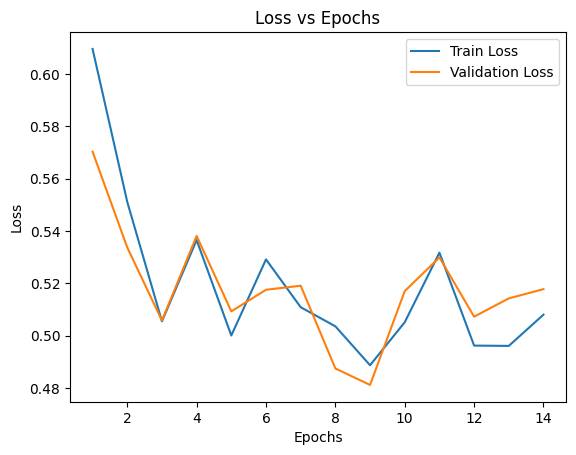

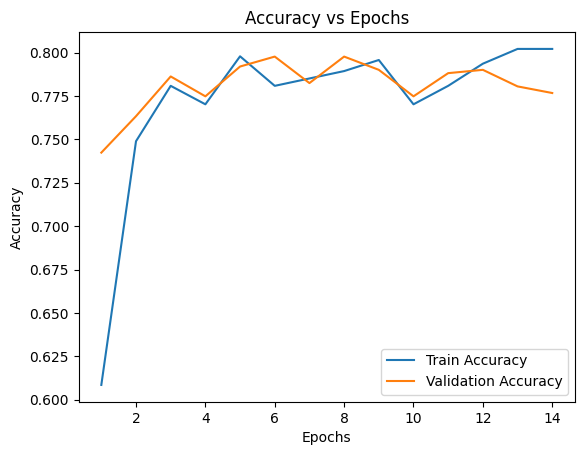

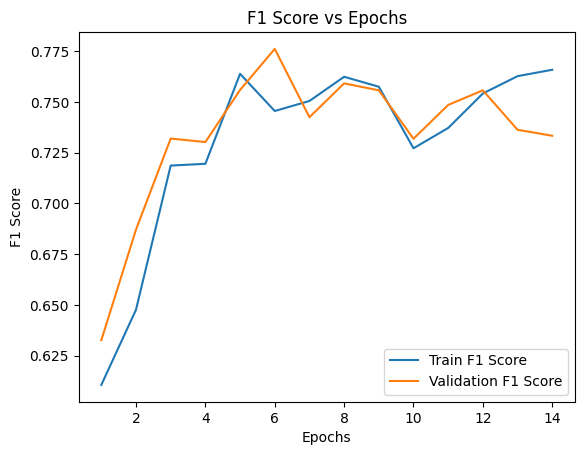

Run 1 - Final Val Accuracy: 0.7767
Run 1 - Final Val F1:       0.7333
Run 1 - Final Val Loss:     0.5177

===== RUN 2/3 (Percentage=10%) =====


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.87it/s]


Epoch [1/30]:
  Train Loss: 0.6927, Accuracy: 0.5915, F1: 0.5936
  Val Loss: 0.6703, Accuracy: 0.7424, F1: 0.6326
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.58it/s]


Epoch [2/30]:
  Train Loss: 0.7319, Accuracy: 0.7426, F1: 0.6328
  Val Loss: 0.7417, Accuracy: 0.7424, F1: 0.6326
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.03it/s]


Epoch [3/30]:
  Train Loss: 0.6821, Accuracy: 0.7426, F1: 0.6328
  Val Loss: 0.5969, Accuracy: 0.7424, F1: 0.6326
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.04it/s]


Epoch [4/30]:
  Train Loss: 0.5501, Accuracy: 0.7660, F1: 0.6844
  Val Loss: 0.5391, Accuracy: 0.7729, F1: 0.7141
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.57it/s]


Epoch [5/30]:
  Train Loss: 0.5590, Accuracy: 0.7660, F1: 0.7380
  Val Loss: 0.5834, Accuracy: 0.7195, F1: 0.7122
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.40it/s]


Epoch [6/30]:
  Train Loss: 0.5530, Accuracy: 0.7681, F1: 0.7450
  Val Loss: 0.5314, Accuracy: 0.7767, F1: 0.7333
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.24it/s]


Epoch [7/30]:
  Train Loss: 0.4979, Accuracy: 0.7936, F1: 0.7490
  Val Loss: 0.5022, Accuracy: 0.7901, F1: 0.7420
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.63it/s]


Epoch [8/30]:
  Train Loss: 0.5040, Accuracy: 0.7936, F1: 0.7433
  Val Loss: 0.5196, Accuracy: 0.7805, F1: 0.7294
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.66it/s]


Epoch [9/30]:
  Train Loss: 0.5333, Accuracy: 0.7851, F1: 0.7327
  Val Loss: 0.5196, Accuracy: 0.7786, F1: 0.7314
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.82it/s]


Epoch [10/30]:
  Train Loss: 0.5518, Accuracy: 0.7681, F1: 0.7137
  Val Loss: 0.4958, Accuracy: 0.7920, F1: 0.7515
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.72it/s]


Epoch [11/30]:
  Train Loss: 0.4743, Accuracy: 0.8064, F1: 0.7645
  Val Loss: 0.5294, Accuracy: 0.7882, F1: 0.7405
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.11it/s]


Epoch [12/30]:
  Train Loss: 0.4598, Accuracy: 0.8064, F1: 0.7708
  Val Loss: 0.5367, Accuracy: 0.7653, F1: 0.7179
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.26it/s]


Epoch [13/30]:
  Train Loss: 0.4893, Accuracy: 0.7936, F1: 0.7557
  Val Loss: 0.5046, Accuracy: 0.7805, F1: 0.7394
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.23it/s]


Epoch [14/30]:
  Train Loss: 0.4922, Accuracy: 0.7872, F1: 0.7521
  Val Loss: 0.5067, Accuracy: 0.7844, F1: 0.7424
No improvement in validation loss for 4 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.72it/s]

Epoch [15/30]:
  Train Loss: 0.4888, Accuracy: 0.7936, F1: 0.7471
  Val Loss: 0.5100, Accuracy: 0.7710, F1: 0.7239
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 0.4888
Final Train Accuracy: 0.7936
Final Train F1: 0.7471
Final Val Loss: 0.5100
Final Val Accuracy: 0.7710
Final Val F1: 0.7239


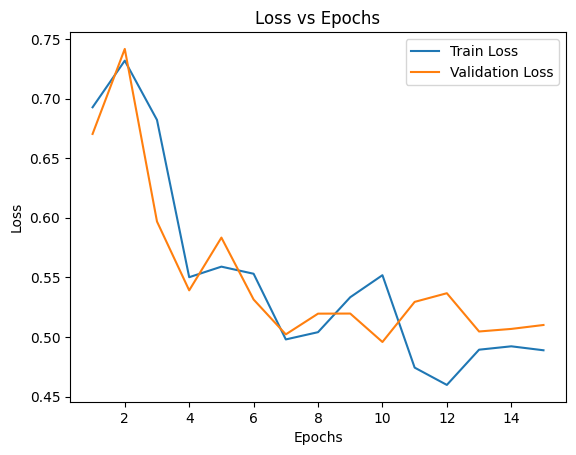

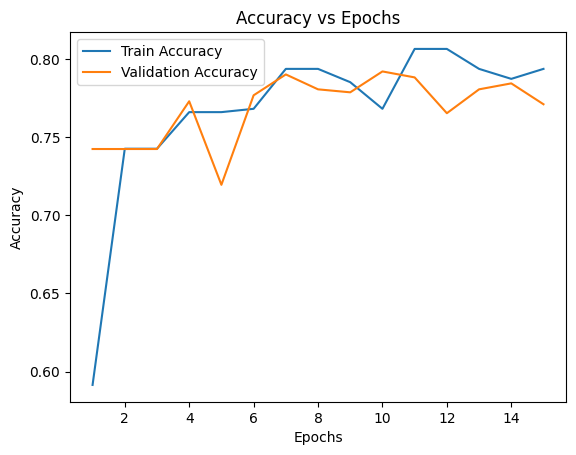

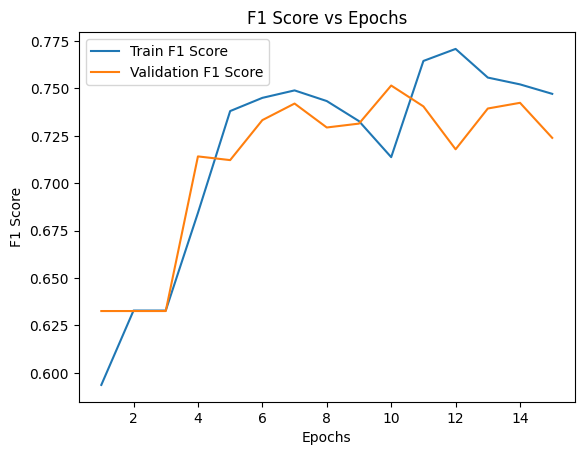

Run 2 - Final Val Accuracy: 0.7710
Run 2 - Final Val F1:       0.7239
Run 2 - Final Val Loss:     0.5100

===== RUN 3/3 (Percentage=10%) =====


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.09it/s]


Epoch [1/30]:
  Train Loss: 0.6126, Accuracy: 0.6319, F1: 0.6314
  Val Loss: 0.5729, Accuracy: 0.7424, F1: 0.6326
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.29it/s]


Epoch [2/30]:
  Train Loss: 0.5813, Accuracy: 0.7426, F1: 0.6328
  Val Loss: 0.5755, Accuracy: 0.7424, F1: 0.6326
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.66it/s]


Epoch [3/30]:
  Train Loss: 0.5630, Accuracy: 0.7596, F1: 0.6710
  Val Loss: 0.5522, Accuracy: 0.7691, F1: 0.7029
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.41it/s]


Epoch [4/30]:
  Train Loss: 0.5271, Accuracy: 0.7787, F1: 0.7337
  Val Loss: 0.5295, Accuracy: 0.7977, F1: 0.7718
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.25it/s]


Epoch [5/30]:
  Train Loss: 0.5261, Accuracy: 0.7894, F1: 0.7473
  Val Loss: 0.5162, Accuracy: 0.7844, F1: 0.7408
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.27it/s]


Epoch [6/30]:
  Train Loss: 0.5003, Accuracy: 0.8064, F1: 0.7610
  Val Loss: 0.5107, Accuracy: 0.7786, F1: 0.7243
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.22it/s]


Epoch [7/30]:
  Train Loss: 0.5098, Accuracy: 0.7787, F1: 0.7237
  Val Loss: 0.4996, Accuracy: 0.7824, F1: 0.7308
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.37it/s]


Epoch [8/30]:
  Train Loss: 0.5170, Accuracy: 0.7809, F1: 0.7209
  Val Loss: 0.5102, Accuracy: 0.7863, F1: 0.7390
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.12it/s]


Epoch [9/30]:
  Train Loss: 0.4837, Accuracy: 0.7979, F1: 0.7541
  Val Loss: 0.5180, Accuracy: 0.7844, F1: 0.7341
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.05it/s]


Epoch [10/30]:
  Train Loss: 0.4920, Accuracy: 0.7872, F1: 0.7403
  Val Loss: 0.4859, Accuracy: 0.7844, F1: 0.7469
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.19it/s]


Epoch [11/30]:
  Train Loss: 0.4690, Accuracy: 0.8128, F1: 0.7819
  Val Loss: 0.4965, Accuracy: 0.7958, F1: 0.7603
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.34it/s]


Epoch [12/30]:
  Train Loss: 0.4976, Accuracy: 0.8000, F1: 0.7625
  Val Loss: 0.5048, Accuracy: 0.7767, F1: 0.7349
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.28it/s]


Epoch [13/30]:
  Train Loss: 0.4960, Accuracy: 0.8064, F1: 0.7737
  Val Loss: 0.5162, Accuracy: 0.7824, F1: 0.7361
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.29it/s]


Epoch [14/30]:
  Train Loss: 0.4888, Accuracy: 0.8043, F1: 0.7705
  Val Loss: 0.4881, Accuracy: 0.7996, F1: 0.7621
No improvement in validation loss for 4 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.13it/s]

Epoch [15/30]:
  Train Loss: 0.5169, Accuracy: 0.7894, F1: 0.7456
  Val Loss: 0.5187, Accuracy: 0.7958, F1: 0.7546
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 0.5169
Final Train Accuracy: 0.7894
Final Train F1: 0.7456
Final Val Loss: 0.5187
Final Val Accuracy: 0.7958
Final Val F1: 0.7546


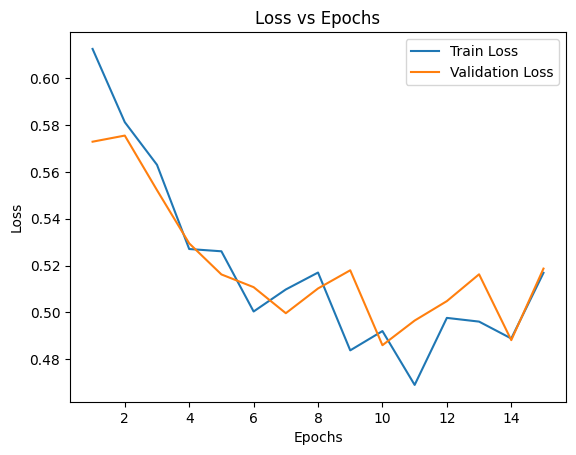

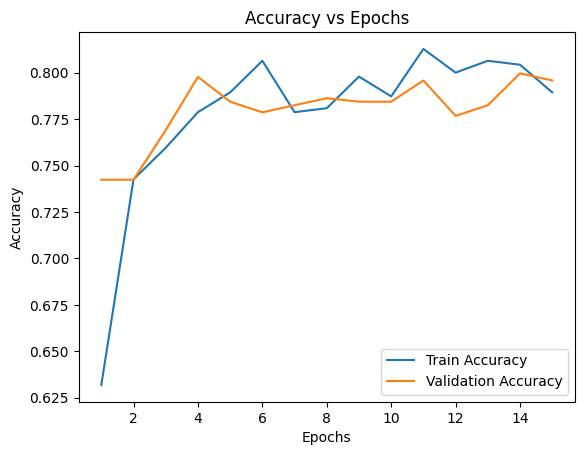

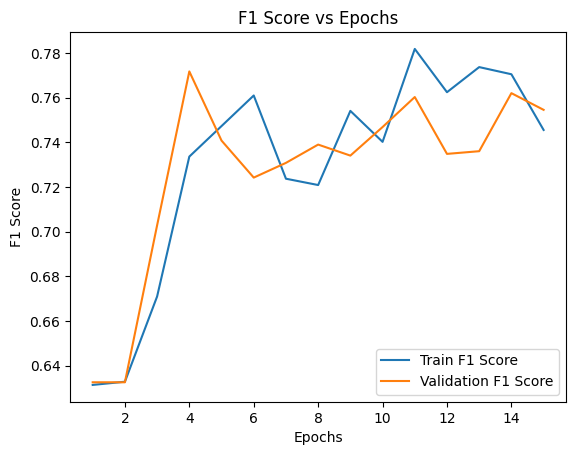

Run 3 - Final Val Accuracy: 0.7958
Run 3 - Final Val F1:       0.7546
Run 3 - Final Val Loss:     0.5187

===== SUMMARY OVER MULTIPLE RUNS =====
Validation Loss: 0.5155 ± 0.0039
Validation Accuracy: 0.7812 ± 0.0106
Validation F1: 0.7373 ± 0.0128

 Final Val Accuracy = 0.7812 ± 0.0106


In [71]:
percentage = 10
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    results = train_subset_model_multiple_runs(
        device=device,
        num_runs=3,
        percentage=10,
        num_epochs=30,
        lr=0.001,
        patience=5,
        accumulation_steps=4,
        seed=42
    )

    print(f"\n Final Val Accuracy = {results['val_acc_mean']:.4f} ± {results['val_acc_std']:.4f}")

# 1% of the data 


===== RUN 1/3 (Percentage=1%) =====


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.00it/s]
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch [1/30]:
  Train Loss: 0.7354, Accuracy: 0.2826, F1: 0.1843
  Val Loss: 0.7392, Accuracy: 0.2691, F1: 0.1415
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.37it/s]


Epoch [2/30]:
  Train Loss: 0.7362, Accuracy: 0.2609, F1: 0.1435
  Val Loss: 0.7412, Accuracy: 0.2710, F1: 0.1452
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.80it/s]


Epoch [3/30]:
  Train Loss: 0.7391, Accuracy: 0.2609, F1: 0.1435
  Val Loss: 0.7390, Accuracy: 0.2805, F1: 0.1608
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.92it/s]


Epoch [4/30]:
  Train Loss: 0.7105, Accuracy: 0.2609, F1: 0.1079
  Val Loss: 0.7451, Accuracy: 0.2767, F1: 0.1505
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.20it/s]


Epoch [5/30]:
  Train Loss: 0.7324, Accuracy: 0.2826, F1: 0.1521
  Val Loss: 0.7370, Accuracy: 0.2767, F1: 0.1564
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.63it/s]


Epoch [6/30]:
  Train Loss: 0.7442, Accuracy: 0.3043, F1: 0.1939
  Val Loss: 0.7405, Accuracy: 0.2672, F1: 0.1408
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.82it/s]


Epoch [7/30]:
  Train Loss: 0.7375, Accuracy: 0.3043, F1: 0.1939
  Val Loss: 0.7435, Accuracy: 0.2729, F1: 0.1519
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.44it/s]


Epoch [8/30]:
  Train Loss: 0.7319, Accuracy: 0.2826, F1: 0.1521
  Val Loss: 0.7422, Accuracy: 0.2576, F1: 0.1280
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.64it/s]


Epoch [9/30]:
  Train Loss: 0.7231, Accuracy: 0.3261, F1: 0.2337
  Val Loss: 0.7345, Accuracy: 0.2939, F1: 0.1778
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.63it/s]


Epoch [10/30]:
  Train Loss: 0.7411, Accuracy: 0.2609, F1: 0.1435
  Val Loss: 0.7364, Accuracy: 0.2863, F1: 0.1746
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.73it/s]


Epoch [11/30]:
  Train Loss: 0.7493, Accuracy: 0.2609, F1: 0.1435
  Val Loss: 0.7369, Accuracy: 0.2748, F1: 0.1467
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.18it/s]


Epoch [12/30]:
  Train Loss: 0.7442, Accuracy: 0.2826, F1: 0.1521
  Val Loss: 0.7364, Accuracy: 0.2844, F1: 0.1624
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.89it/s]


Epoch [13/30]:
  Train Loss: 0.7386, Accuracy: 0.2609, F1: 0.1079
  Val Loss: 0.7395, Accuracy: 0.2748, F1: 0.1497
No improvement in validation loss for 4 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.94it/s]

Epoch [14/30]:
  Train Loss: 0.7115, Accuracy: 0.2609, F1: 0.1079
  Val Loss: 0.7378, Accuracy: 0.2691, F1: 0.1322
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 0.7115
Final Train Accuracy: 0.2609
Final Train F1: 0.1079
Final Val Loss: 0.7378
Final Val Accuracy: 0.2691
Final Val F1: 0.1322


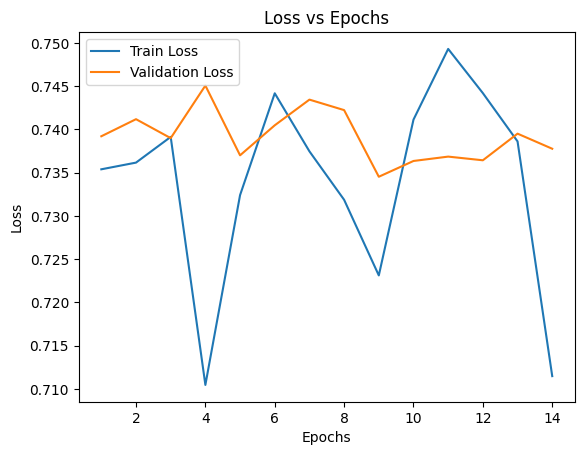

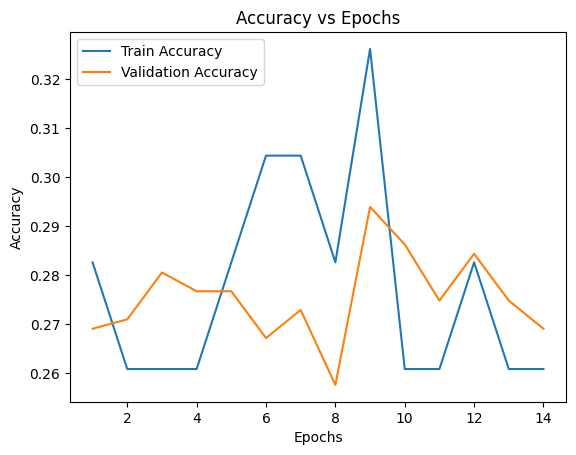

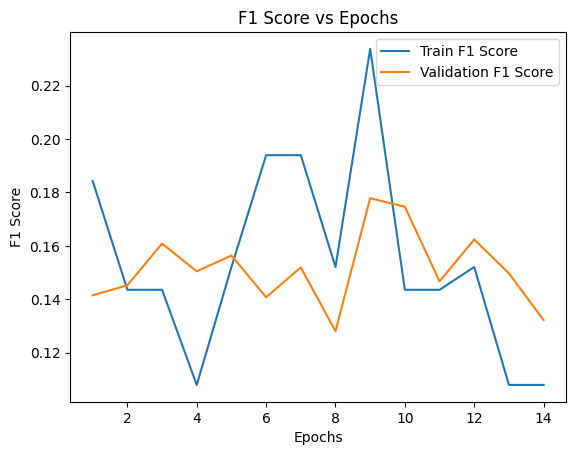

Run 1 - Final Val Accuracy: 0.2691
Run 1 - Final Val F1:       0.1322
Run 1 - Final Val Loss:     0.7378

===== RUN 2/3 (Percentage=1%) =====


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.49it/s]
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch [1/30]:
  Train Loss: 0.7346, Accuracy: 0.3043, F1: 0.1939
  Val Loss: 0.7558, Accuracy: 0.2328, F1: 0.1067
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.86it/s]


Epoch [2/30]:
  Train Loss: 0.7456, Accuracy: 0.2609, F1: 0.1079
  Val Loss: 0.7516, Accuracy: 0.2481, F1: 0.1184
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.67it/s]


Epoch [3/30]:
  Train Loss: 0.7224, Accuracy: 0.2826, F1: 0.1521
  Val Loss: 0.7536, Accuracy: 0.2462, F1: 0.1208
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.89it/s]


Epoch [4/30]:
  Train Loss: 0.7421, Accuracy: 0.2609, F1: 0.1079
  Val Loss: 0.7586, Accuracy: 0.2405, F1: 0.1156
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.28it/s]


Epoch [5/30]:
  Train Loss: 0.7501, Accuracy: 0.2826, F1: 0.1521
  Val Loss: 0.7495, Accuracy: 0.2462, F1: 0.1177
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.31it/s]


Epoch [6/30]:
  Train Loss: 0.7554, Accuracy: 0.2391, F1: 0.1007
  Val Loss: 0.7501, Accuracy: 0.2519, F1: 0.1198
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.74it/s]


Epoch [7/30]:
  Train Loss: 0.7552, Accuracy: 0.2609, F1: 0.1079
  Val Loss: 0.7555, Accuracy: 0.2443, F1: 0.1231
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.35it/s]


Epoch [8/30]:
  Train Loss: 0.7389, Accuracy: 0.2609, F1: 0.1079
  Val Loss: 0.7546, Accuracy: 0.2328, F1: 0.1036
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.44it/s]


Epoch [9/30]:
  Train Loss: 0.7460, Accuracy: 0.2609, F1: 0.1079
  Val Loss: 0.7563, Accuracy: 0.2405, F1: 0.1094
No improvement in validation loss for 4 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.80it/s]


Epoch [10/30]:
  Train Loss: 0.7449, Accuracy: 0.2391, F1: 0.1007
  Val Loss: 0.7572, Accuracy: 0.2385, F1: 0.1025
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 0.7449
Final Train Accuracy: 0.2391
Final Train F1: 0.1007
Final Val Loss: 0.7572
Final Val Accuracy: 0.2385
Final Val F1: 0.1025


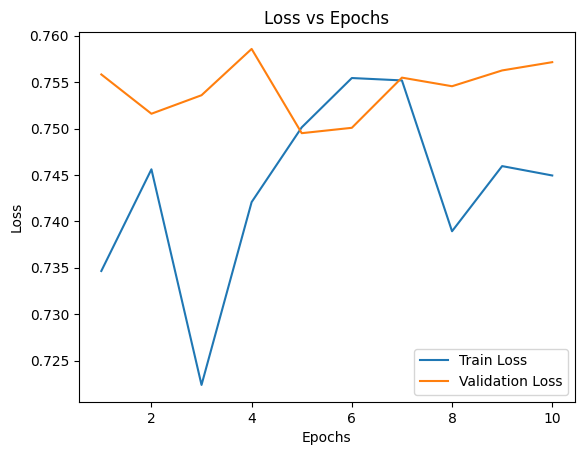

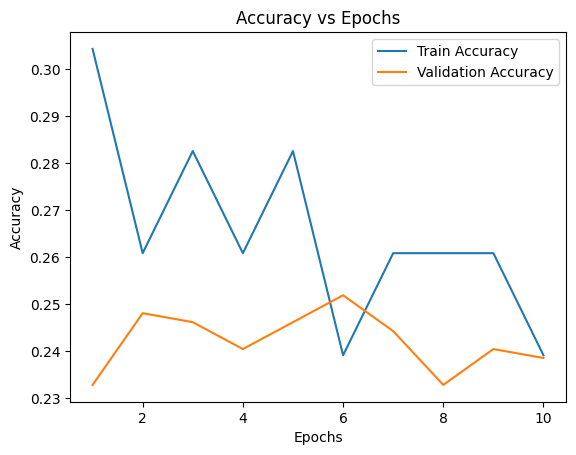

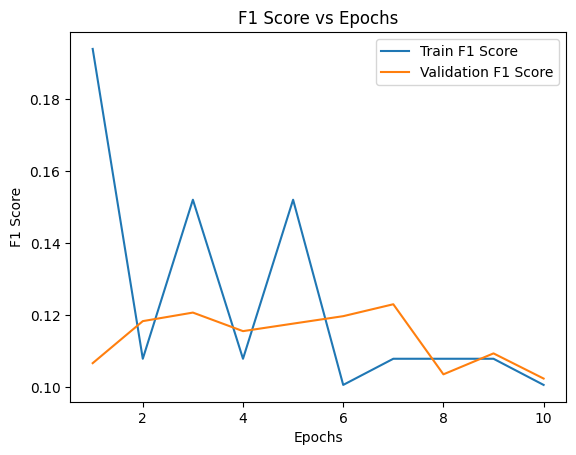

Run 2 - Final Val Accuracy: 0.2385
Run 2 - Final Val F1:       0.1025
Run 2 - Final Val Loss:     0.7572

===== RUN 3/3 (Percentage=1%) =====


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.59it/s]
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch [1/30]:
  Train Loss: 0.7237, Accuracy: 0.3043, F1: 0.1939
  Val Loss: 0.7372, Accuracy: 0.2920, F1: 0.2011
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.17it/s]


Epoch [2/30]:
  Train Loss: 0.7308, Accuracy: 0.2826, F1: 0.2122
  Val Loss: 0.7301, Accuracy: 0.2996, F1: 0.2170
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.09it/s]


Epoch [3/30]:
  Train Loss: 0.7251, Accuracy: 0.2609, F1: 0.1435
  Val Loss: 0.7299, Accuracy: 0.3092, F1: 0.2241
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.45it/s]


Epoch [4/30]:
  Train Loss: 0.7367, Accuracy: 0.2391, F1: 0.1644
  Val Loss: 0.7311, Accuracy: 0.3092, F1: 0.2289
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.58it/s]


Epoch [5/30]:
  Train Loss: 0.7439, Accuracy: 0.3043, F1: 0.1939
  Val Loss: 0.7332, Accuracy: 0.2863, F1: 0.1984
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.68it/s]


Epoch [6/30]:
  Train Loss: 0.7433, Accuracy: 0.2826, F1: 0.1843
  Val Loss: 0.7316, Accuracy: 0.3034, F1: 0.2189
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.88it/s]


Epoch [7/30]:
  Train Loss: 0.7455, Accuracy: 0.2826, F1: 0.2122
  Val Loss: 0.7332, Accuracy: 0.2863, F1: 0.1882
No improvement in validation loss for 4 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.69it/s]


Epoch [8/30]:
  Train Loss: 0.7311, Accuracy: 0.2826, F1: 0.2122
  Val Loss: 0.7270, Accuracy: 0.3092, F1: 0.2241
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.50it/s]


Epoch [9/30]:
  Train Loss: 0.7376, Accuracy: 0.2391, F1: 0.1007
  Val Loss: 0.7285, Accuracy: 0.2996, F1: 0.2218
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.49it/s]


Epoch [10/30]:
  Train Loss: 0.7360, Accuracy: 0.3043, F1: 0.1939
  Val Loss: 0.7307, Accuracy: 0.2920, F1: 0.2133
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.60it/s]


Epoch [11/30]:
  Train Loss: 0.7457, Accuracy: 0.3261, F1: 0.2337
  Val Loss: 0.7289, Accuracy: 0.2977, F1: 0.2113
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.25it/s]


Epoch [12/30]:
  Train Loss: 0.7321, Accuracy: 0.2609, F1: 0.1744
  Val Loss: 0.7297, Accuracy: 0.3149, F1: 0.2388
No improvement in validation loss for 4 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.28it/s]

Epoch [13/30]:
  Train Loss: 0.7291, Accuracy: 0.2826, F1: 0.1843
  Val Loss: 0.7300, Accuracy: 0.3073, F1: 0.2279
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 0.7291
Final Train Accuracy: 0.2826
Final Train F1: 0.1843
Final Val Loss: 0.7300
Final Val Accuracy: 0.3073
Final Val F1: 0.2279


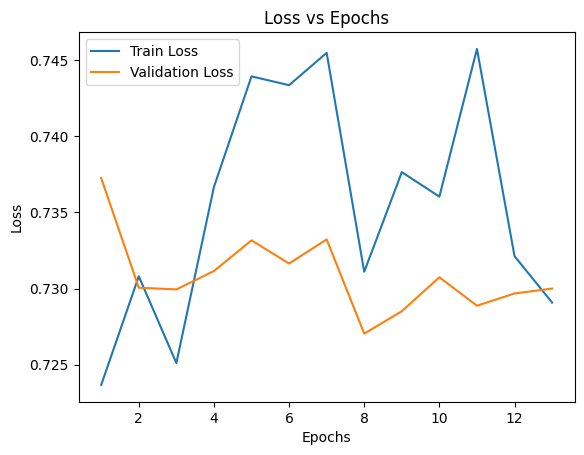

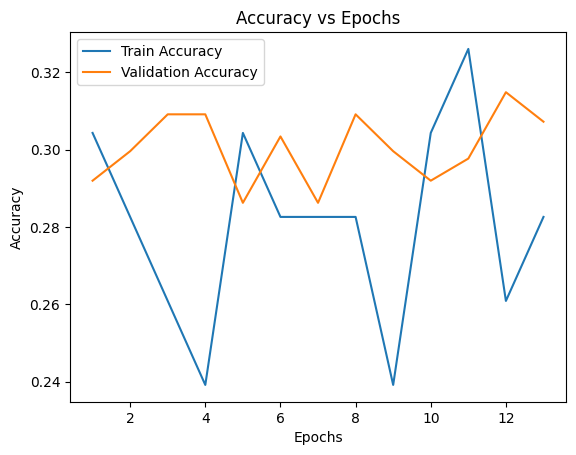

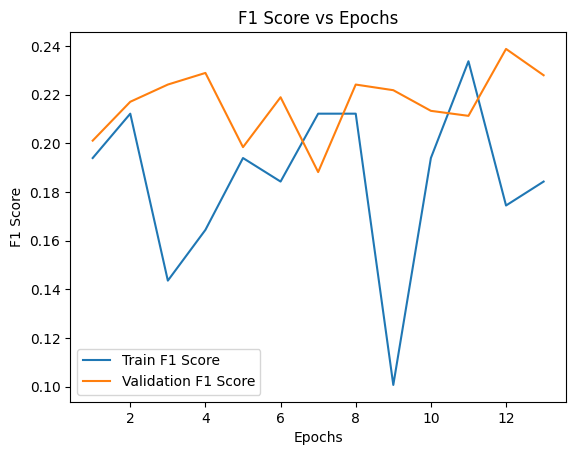

Run 3 - Final Val Accuracy: 0.3073
Run 3 - Final Val F1:       0.2279
Run 3 - Final Val Loss:     0.7300

===== SUMMARY OVER MULTIPLE RUNS =====
Validation Loss: 0.7416 ± 0.0114
Validation Accuracy: 0.2716 ± 0.0281
Validation F1: 0.1542 ± 0.0535

 Final Val Accuracy = 0.2716 ± 0.0281


In [72]:
percentage = 1
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    results = train_subset_model_multiple_runs(
        device=device,
        num_runs=3,
        percentage=1,
        num_epochs=30,
        lr=0.001,
        patience=5,
        accumulation_steps=4,
        seed=42
    )

    print(f"\n Final Val Accuracy = {results['val_acc_mean']:.4f} ± {results['val_acc_std']:.4f}")

# 0.1% of the data 


===== RUN 1/3 (Percentage=0.1%) =====


Validating: 100%|██████████| 17/17 [00:01<00:00,  9.32it/s]
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch [1/30]:
  Train Loss: 0.6663, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7415, Accuracy: 0.2729, F1: 0.1429
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.11it/s]


Epoch [2/30]:
  Train Loss: 0.7053, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7407, Accuracy: 0.2786, F1: 0.1601
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00,  9.59it/s]


Epoch [3/30]:
  Train Loss: 0.7299, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7427, Accuracy: 0.2786, F1: 0.1601
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00,  9.98it/s]


Epoch [4/30]:
  Train Loss: 0.7540, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7392, Accuracy: 0.2767, F1: 0.1474
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.73it/s]


Epoch [5/30]:
  Train Loss: 0.7524, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7390, Accuracy: 0.2863, F1: 0.1718
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.18it/s]


Epoch [6/30]:
  Train Loss: 0.6966, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7423, Accuracy: 0.2595, F1: 0.1318
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.77it/s]


Epoch [7/30]:
  Train Loss: 0.7378, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7408, Accuracy: 0.2805, F1: 0.1666
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.87it/s]


Epoch [8/30]:
  Train Loss: 0.7175, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7416, Accuracy: 0.2653, F1: 0.1370
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.05it/s]


Epoch [9/30]:
  Train Loss: 0.6500, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7381, Accuracy: 0.2786, F1: 0.1571
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.83it/s]


Epoch [10/30]:
  Train Loss: 0.7645, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7409, Accuracy: 0.2729, F1: 0.1460
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.46it/s]


Epoch [11/30]:
  Train Loss: 0.7060, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7385, Accuracy: 0.2710, F1: 0.1569
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.59it/s]


Epoch [12/30]:
  Train Loss: 0.7444, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7349, Accuracy: 0.2786, F1: 0.1542
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.71it/s]


Epoch [13/30]:
  Train Loss: 0.7574, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7387, Accuracy: 0.2653, F1: 0.1400
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.03it/s]


Epoch [14/30]:
  Train Loss: 0.7249, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7376, Accuracy: 0.2748, F1: 0.1467
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00,  9.85it/s]


Epoch [15/30]:
  Train Loss: 0.7368, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7333, Accuracy: 0.2729, F1: 0.1399
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.39it/s]


Epoch [16/30]:
  Train Loss: 0.7620, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7360, Accuracy: 0.2805, F1: 0.1579
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.36it/s]


Epoch [17/30]:
  Train Loss: 0.7540, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7377, Accuracy: 0.2882, F1: 0.1697
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.21it/s]


Epoch [18/30]:
  Train Loss: 0.7103, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7344, Accuracy: 0.2824, F1: 0.1645
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00,  9.89it/s]


Epoch [19/30]:
  Train Loss: 0.7593, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7390, Accuracy: 0.2710, F1: 0.1452
No improvement in validation loss for 4 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00,  9.71it/s]


Epoch [20/30]:
  Train Loss: 0.7365, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7393, Accuracy: 0.2672, F1: 0.1315
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 0.7365
Final Train Accuracy: 0.2500
Final Train F1: 0.1000
Final Val Loss: 0.7393
Final Val Accuracy: 0.2672
Final Val F1: 0.1315


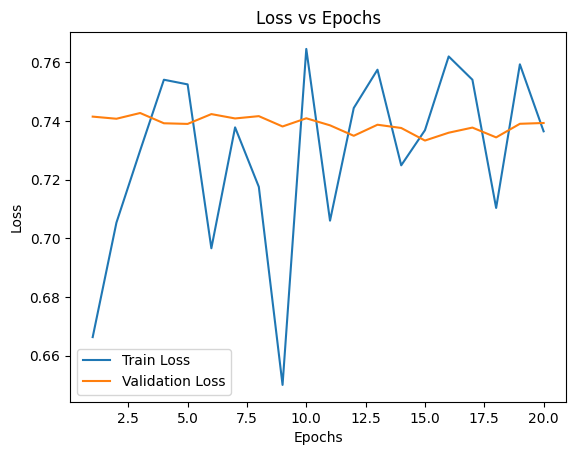

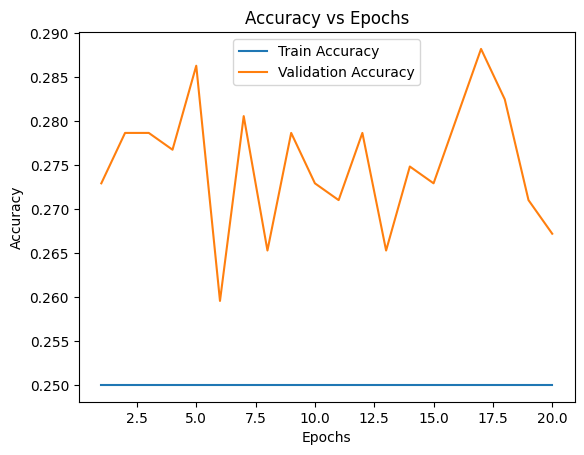

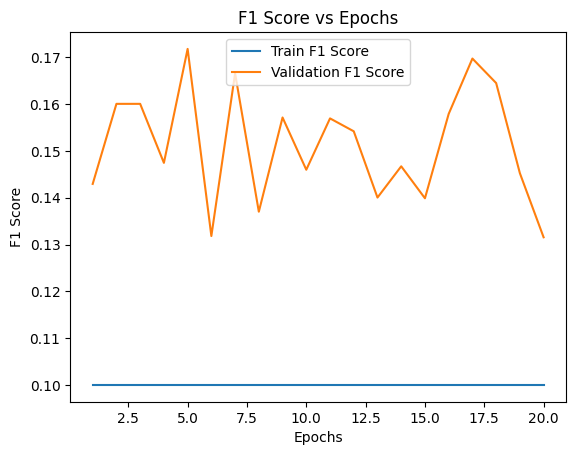

Run 1 - Final Val Accuracy: 0.2672
Run 1 - Final Val F1:       0.1315
Run 1 - Final Val Loss:     0.7393

===== RUN 2/3 (Percentage=0.1%) =====


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.20it/s]
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch [1/30]:
  Train Loss: 0.7159, Accuracy: 0.5000, F1: 0.5000
  Val Loss: 0.7562, Accuracy: 0.2290, F1: 0.1054
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00,  9.98it/s]


Epoch [2/30]:
  Train Loss: 0.7652, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7507, Accuracy: 0.2462, F1: 0.1083
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.52it/s]


Epoch [3/30]:
  Train Loss: 0.7662, Accuracy: 0.0000, F1: 0.0000
  Val Loss: 0.7540, Accuracy: 0.2519, F1: 0.1166
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.42it/s]


Epoch [4/30]:
  Train Loss: 0.7319, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7544, Accuracy: 0.2538, F1: 0.1266
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.52it/s]


Epoch [5/30]:
  Train Loss: 0.7382, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7566, Accuracy: 0.2366, F1: 0.1112
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.67it/s]


Epoch [6/30]:
  Train Loss: 0.7998, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7514, Accuracy: 0.2481, F1: 0.1245
No improvement in validation loss for 4 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.47it/s]


Epoch [7/30]:
  Train Loss: 0.8110, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7569, Accuracy: 0.2481, F1: 0.1215
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 0.8110
Final Train Accuracy: 0.2500
Final Train F1: 0.1000
Final Val Loss: 0.7569
Final Val Accuracy: 0.2481
Final Val F1: 0.1215


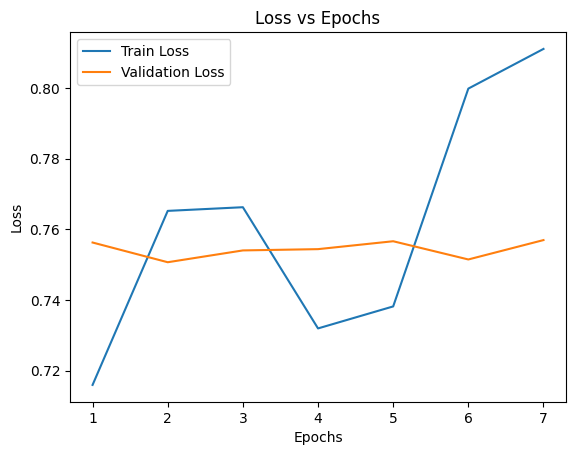

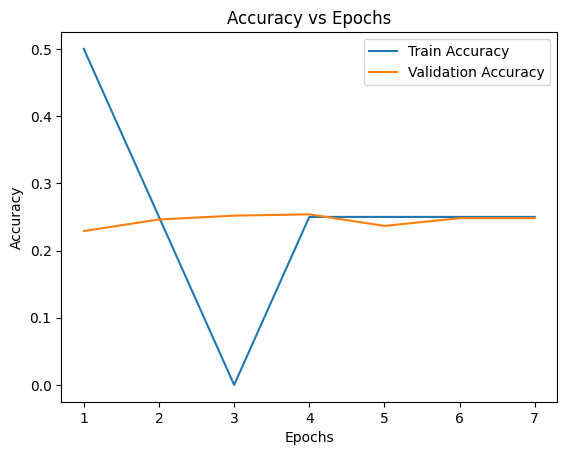

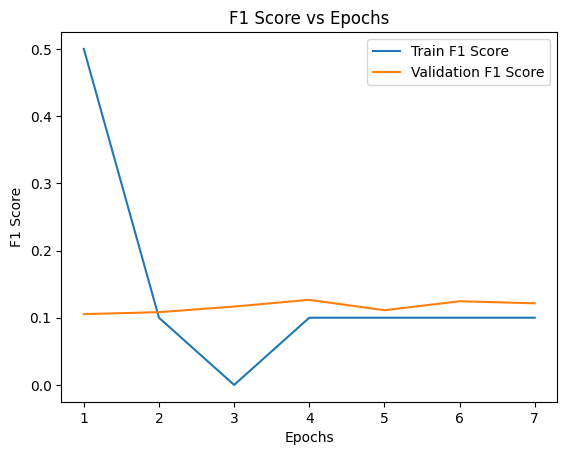

Run 2 - Final Val Accuracy: 0.2481
Run 2 - Final Val F1:       0.1215
Run 2 - Final Val Loss:     0.7569

===== RUN 3/3 (Percentage=0.1%) =====


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.96it/s]
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch [1/30]:
  Train Loss: 0.7247, Accuracy: 0.5000, F1: 0.5000
  Val Loss: 0.7349, Accuracy: 0.2786, F1: 0.1795
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.91it/s]


Epoch [2/30]:
  Train Loss: 0.7338, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7260, Accuracy: 0.3111, F1: 0.2368
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.40it/s]


Epoch [3/30]:
  Train Loss: 0.7356, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7305, Accuracy: 0.3034, F1: 0.2284
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.39it/s]


Epoch [4/30]:
  Train Loss: 0.7159, Accuracy: 0.5000, F1: 0.5000
  Val Loss: 0.7294, Accuracy: 0.3187, F1: 0.2453
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.30it/s]


Epoch [5/30]:
  Train Loss: 0.7327, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7321, Accuracy: 0.2958, F1: 0.2054
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.77it/s]


Epoch [6/30]:
  Train Loss: 0.7688, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7302, Accuracy: 0.3168, F1: 0.2374
No improvement in validation loss for 4 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.19it/s]

Epoch [7/30]:
  Train Loss: 0.7233, Accuracy: 0.5000, F1: 0.5000
  Val Loss: 0.7287, Accuracy: 0.3168, F1: 0.2351
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 0.7233
Final Train Accuracy: 0.5000
Final Train F1: 0.5000
Final Val Loss: 0.7287
Final Val Accuracy: 0.3168
Final Val F1: 0.2351


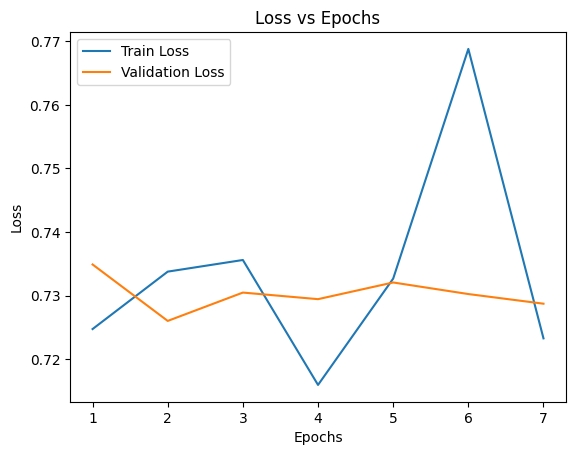

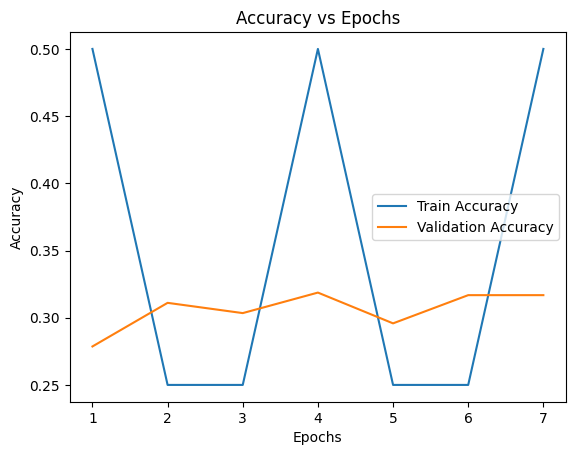

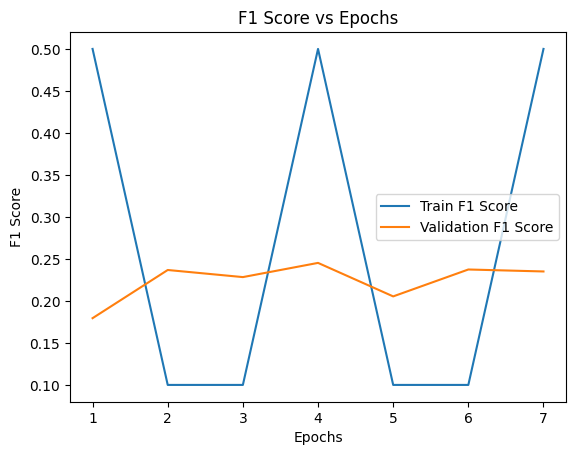

Run 3 - Final Val Accuracy: 0.3168
Run 3 - Final Val F1:       0.2351
Run 3 - Final Val Loss:     0.7287

===== SUMMARY OVER MULTIPLE RUNS =====
Validation Loss: 0.7416 ± 0.0116
Validation Accuracy: 0.2774 ± 0.0290
Validation F1: 0.1627 ± 0.0513

 Final Val Accuracy = 0.2774 ± 0.0290


In [74]:
percentage = 0.1
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    results = train_subset_model_multiple_runs(
        device=device,
        num_runs=3,
        percentage=0.1,
        num_epochs=30,
        lr=0.001,
        patience=5,
        accumulation_steps=4,
        seed=42
    )

    print(f"\n Final Val Accuracy = {results['val_acc_mean']:.4f} ± {results['val_acc_std']:.4f}")

# EP experiment

In [78]:

class VGG16FeatureExtractor(nn.Module):
    """
    Loads the VGG16 from timm, removes the final classifier,
    and outputs the penultimate layer features.
    """
    def __init__(self):
        super().__init__()
        self.model = create_model("vgg16", pretrained=False, num_classes=1000)

    def forward(self, x):
        feats = self.model.forward_features(x)  # shape [batch_size, C, H, W]
        feats = feats.view(feats.size(0), -1)   # flatten
        return feats

def load_vgg_features_model(best_model_path, device):
    feature_extractor = VGG16FeatureExtractor()
    
    #  full state dict
    state_dict = torch.load(best_model_path, map_location=device)

    #  strict=False to skip mismatches:
    feature_extractor.model.load_state_dict(state_dict, strict=False)

    feature_extractor.eval()
    feature_extractor.to(device)

    return feature_extractor

def extract_features(model, dataloader, device):
    features_list = []
    with torch.no_grad():
        for batch_images, _ in dataloader:
            batch_images = batch_images.to(device)
            # forward to get features
            batch_feats = model(batch_images)  # shape [B, feature_dim]
            features_list.append(batch_feats.cpu())

    all_features = torch.cat(features_list, dim=0)  # shape [N, feature_dim]
    return all_features

def embedding_propagation(features: torch.Tensor,
                          alpha: float = 0.5,
                          sigma_factor: float = 1.0) -> torch.Tensor:
    """
    Given a feature matrix (N x m)
    Args:
        features (torch.Tensor): shape (N, m) where N is #samples, m is #dims
        alpha (float): scaling factor in (I - alpha L)^(-1)
        sigma_factor (float): a factor multiplied by distance variance

    Returns:
        torch.Tensor: The propagated embeddings (N, m).
    """

    device = features.device
    # 1) Pairwise distances
    distances = torch.cdist(features, features, p=2)  # (N, N)
    sigma_squared = distances.var().item() * sigma_factor

    # 2) Adjacency
    adjacency_matrix = torch.exp(-distances / sigma_squared)  # (N, N)
    adjacency_matrix.fill_diagonal_(0)

    # 3) Laplacian
    degree_matrix = torch.diag(adjacency_matrix.sum(dim=1))
    D_inv_sqrt = torch.diag(1.0 / torch.sqrt(degree_matrix.diag()))
    laplacian = D_inv_sqrt @ adjacency_matrix @ D_inv_sqrt

    # 4) Propagator
    N = laplacian.size(0)
    identity_matrix = torch.eye(N, device=device)
    # (I - alpha * L)^-1
    propagator = inv(identity_matrix - alpha * laplacian)

    # 5) Propagated embeddings
    propagated_embeddings = propagator @ features
    return propagated_embeddings


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_model_path = "vvgg_full_pneumonia.pth"
feature_extractor = load_vgg_features_model(best_model_path, device)

train_images_path = "/home/dime/Desktop/Pre-thesis/data/pneumoniamnist_224/train_images.npy"
train_labels_path = "/home/dime/Desktop/Pre-thesis/data/pneumoniamnist_224/train_labels.npy"
train_dataset = NumpyDataset(train_images_path, train_labels_path, transform=None)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

all_features = extract_features(feature_extractor, train_loader, device)
print("Feature shape:", all_features.shape)  # e.g. [N, 4096] or so

propagated = embedding_propagation(all_features.to(device), alpha=0.5, sigma_factor=1.0)
propagated = propagated.cpu()  # if you want it back on CPU

torch.save(propagated, "vgg_propagated_embeddings.pth")
print("Saved propagated embeddings to vgg_propagated_embeddings.pth")

Feature shape: torch.Size([4708, 25088])
Saved propagated embeddings to vgg_propagated_embeddings.pth


In [89]:
def ep_subset_dataset_percentage(
    dataset,
    embeddings_path,
    percentage=percentage,
    seed=42
):
    random.seed(seed)
    np.random.seed(seed)

    embeddings = torch.load(embeddings_path)  # shape [N, feature_dim]
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.cpu().numpy()

    N = embeddings.shape[0]
    n_clusters = max(1, int(N * (percentage / 100.0)))

    print(f"EP subset => Using KMeans with n_clusters={n_clusters}, i.e. ~{percentage}% of data.")
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
    kmeans.fit(embeddings)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_


    selected_indices = []
    for cluster_id in range(n_clusters):
        cluster_pts_idx = np.where(labels == cluster_id)[0]
        cluster_pts = embeddings[cluster_pts_idx]
        centroid = centroids[cluster_id]
        dists = np.linalg.norm(cluster_pts - centroid, axis=1)
        best_idx = np.argmin(dists)
        selected_indices.append(cluster_pts_idx[best_idx])

    selected_indices = np.array(selected_indices)
    print(f"Selected {len(selected_indices)} representatives out of {N} total.")


    return Subset(dataset, selected_indices)

def load_data_subset(
    embeddings_path, 
    percentage, 
    batch_size=batch_size, 
    img_size=img_size
):
    train_dataset = NumpyDataset(os.path.join(path, 'train_images.npy'), os.path.join(path, 'train_labels.npy'), transform)
    val_dataset = NumpyDataset(os.path.join(path, 'val_images.npy'), os.path.join(path, 'val_labels.npy'), transform)
    test_dataset = NumpyDataset(os.path.join(path, 'test_images.npy'), os.path.join(path, 'test_labels.npy'), transform)


    train_subset = ep_subset_dataset_percentage(
        dataset=train_dataset,
        embeddings_path=embeddings_path,
        percentage=percentage, 
        seed=42
    )

    val_subset = val_dataset
    test_subset = test_dataset

    train_loader_subset = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader_subset   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False)
    test_loader_subset  = DataLoader(test_subset,  batch_size=batch_size, shuffle=False)

    return train_loader_subset, val_loader_subset, test_loader_subset

def train_subset_model(
    model,
    train_loader_subset,
    val_loader_subset,
    device,
    num_epochs=30,
    lr=0.001,
    patience=5,
    accumulation_steps=4
):

    metrics_log = {
        "train_loss": [],
        "train_accuracy": [],
        "train_f1": [],
        "val_loss": [],
        "val_accuracy": [],
        "val_f1": []
    }

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = torch.cuda.amp.GradScaler()

    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_labels, all_preds = [], []

        for step, (images, labels) in enumerate(tqdm(train_loader_subset, desc=f"Training Epoch {epoch+1}/{num_epochs}")):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels) / accumulation_steps

            scaler.scale(loss).backward()

            if (step + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            running_loss += loss.item() * accumulation_steps
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        train_accuracy = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        train_loss = running_loss / len(train_loader_subset)

        model.eval()
        val_loss_total = 0.0
        val_labels, val_preds = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader_subset, desc="Validating"):
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                val_loss_total += loss.item()

                _, predicted = outputs.max(1)
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(predicted.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        val_loss_avg = val_loss_total / len(val_loader_subset)

        metrics_log["train_loss"].append(train_loss)
        metrics_log["train_accuracy"].append(train_accuracy)
        metrics_log["train_f1"].append(train_f1)
        metrics_log["val_loss"].append(val_loss_avg)
        metrics_log["val_accuracy"].append(val_accuracy)
        metrics_log["val_f1"].append(val_f1)

        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}]:")
        print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")
        print(f"  Val Loss: {val_loss_avg:.4f}, Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")

        # Early stopping check
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            patience_counter = 0
            torch.save(model.state_dict(), "vgg_best_10%.pth")
            print("Validation loss improved. Model saved.")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epoch(s).")

        if patience_counter >= patience:
            print("Early stopping")
            break

    # Optionally, plot or print final
    print(f"Final Train Loss: {metrics_log['train_loss'][-1]:.4f}")
    print(f"Final Train Accuracy: {metrics_log['train_accuracy'][-1]:.4f}")
    print(f"Final Train F1: {metrics_log['train_f1'][-1]:.4f}")
    print(f"Final Val Loss: {metrics_log['val_loss'][-1]:.4f}")
    print(f"Final Val Accuracy: {metrics_log['val_accuracy'][-1]:.4f}")
    print(f"Final Val F1: {metrics_log['val_f1'][-1]:.4f}")

    plot_metrics(metrics_log)
    return metrics_log

In [90]:
def train_subset_model_multiple_runs(
    device,
    num_runs=3,
    percentage=percentage,
    num_epochs=30,
    lr=0.001,
    patience=5,
    accumulation_steps=4,
    seed=42,
    embeddings_path="/home/dime/Desktop/Pre-thesis/vgg_propagated_embeddings.pth"
):
    #set_seed(seed)

    train_loader_subset, val_loader_subset, test_loader_subset = load_data_subset(
        batch_size=batch_size,
        img_size=img_size,
        percentage=percentage,         
        embeddings_path=embeddings_path,  
    )

    val_accuracies = []
    val_f1s = []
    val_losses = []

    for run_idx in range(num_runs):
        print(f"\n===== RUN {run_idx + 1}/{num_runs} (Percentage={percentage}%) =====")

        set_seed(seed + run_idx)  
        model = VGG16(num_classes=num_classes)

        metrics_log = train_subset_model(
            model=model,
            train_loader_subset=train_loader_subset,
            val_loader_subset=val_loader_subset,
            device=device,
            num_epochs=num_epochs,
            lr=lr,
            patience=patience,
            accumulation_steps=accumulation_steps
        )

        final_val_accuracy = metrics_log["val_accuracy"][-1]
        final_val_f1 = metrics_log["val_f1"][-1]
        final_val_loss = metrics_log["val_loss"][-1]

        val_accuracies.append(final_val_accuracy)
        val_f1s.append(final_val_f1)
        val_losses.append(final_val_loss)

        print(f"Run {run_idx+1} => ValAcc: {final_val_accuracy:.4f}, ValF1: {final_val_f1:.4f}, ValLoss: {final_val_loss:.4f}")

    val_loss_mean = np.mean(val_losses)
    val_loss_std = np.std(val_losses)
    val_acc_mean = np.mean(val_accuracies)
    val_acc_std = np.std(val_accuracies)
    val_f1_mean = np.mean(val_f1s)
    val_f1_std = np.std(val_f1s)

    print("\n===== SUMMARY OVER MULTIPLE RUNS =====")
    print(f"Validation Loss: {val_loss_mean:.4f} ± {val_loss_std:.4f}")
    print(f"Validation Accuracy: {val_acc_mean:.4f} ± {val_acc_std:.4f}")
    print(f"Validation F1: {val_f1_mean:.4f} ± {val_f1_std:.4f}")

    return {
        "val_loss_mean": val_loss_mean,
        "val_loss_std": val_loss_std,
        "val_acc_mean": val_acc_mean,
        "val_acc_std": val_acc_std,
        "val_f1_mean": val_f1_mean,
        "val_f1_std": val_f1_std
    }

## EP 0.1%

EP subset => Using KMeans with n_clusters=4, i.e. ~0.1% of data.
Selected 4 representatives out of 4708 total.

===== RUN 1/3 (Percentage=0.1%) =====


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.87it/s]


Epoch [1/30]:
  Train Loss: 0.7201, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7415, Accuracy: 0.2729, F1: 0.1429
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.25it/s]


Epoch [2/30]:
  Train Loss: 0.7352, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7407, Accuracy: 0.2786, F1: 0.1601
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.58it/s]


Epoch [3/30]:
  Train Loss: 0.7620, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7427, Accuracy: 0.2786, F1: 0.1601
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.75it/s]


Epoch [4/30]:
  Train Loss: 0.6871, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7392, Accuracy: 0.2767, F1: 0.1474
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.44it/s]


Epoch [5/30]:
  Train Loss: 0.7266, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7390, Accuracy: 0.2863, F1: 0.1718
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.53it/s]


Epoch [6/30]:
  Train Loss: 0.7747, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7423, Accuracy: 0.2595, F1: 0.1318
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.62it/s]


Epoch [7/30]:
  Train Loss: 0.7725, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7408, Accuracy: 0.2805, F1: 0.1666
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.55it/s]


Epoch [8/30]:
  Train Loss: 0.7215, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7416, Accuracy: 0.2653, F1: 0.1370
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.90it/s]


Epoch [9/30]:
  Train Loss: 0.7278, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7381, Accuracy: 0.2786, F1: 0.1571
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.42it/s]


Epoch [10/30]:
  Train Loss: 0.7625, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7409, Accuracy: 0.2729, F1: 0.1460
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.20it/s]


Epoch [11/30]:
  Train Loss: 0.7156, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7385, Accuracy: 0.2710, F1: 0.1569
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.84it/s]


Epoch [12/30]:
  Train Loss: 0.7098, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7349, Accuracy: 0.2786, F1: 0.1542
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.72it/s]


Epoch [13/30]:
  Train Loss: 0.6946, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7387, Accuracy: 0.2653, F1: 0.1400
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.27it/s]


Epoch [14/30]:
  Train Loss: 0.7249, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7376, Accuracy: 0.2748, F1: 0.1467
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.55it/s]


Epoch [15/30]:
  Train Loss: 0.7274, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7333, Accuracy: 0.2729, F1: 0.1399
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.55it/s]


Epoch [16/30]:
  Train Loss: 0.7640, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7360, Accuracy: 0.2805, F1: 0.1579
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.43it/s]


Epoch [17/30]:
  Train Loss: 0.7228, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7377, Accuracy: 0.2882, F1: 0.1697
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.07it/s]


Epoch [18/30]:
  Train Loss: 0.7056, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7344, Accuracy: 0.2824, F1: 0.1645
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.33it/s]


Epoch [19/30]:
  Train Loss: 0.7366, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7390, Accuracy: 0.2710, F1: 0.1452
No improvement in validation loss for 4 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.43it/s]

Epoch [20/30]:
  Train Loss: 0.7106, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7393, Accuracy: 0.2672, F1: 0.1315
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 0.7106
Final Train Accuracy: 0.2500
Final Train F1: 0.1000
Final Val Loss: 0.7393
Final Val Accuracy: 0.2672
Final Val F1: 0.1315


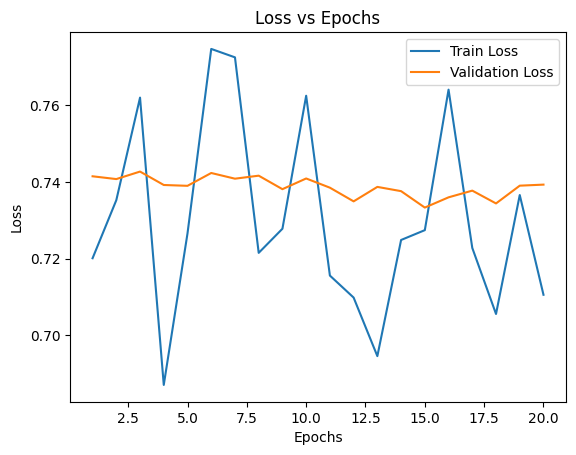

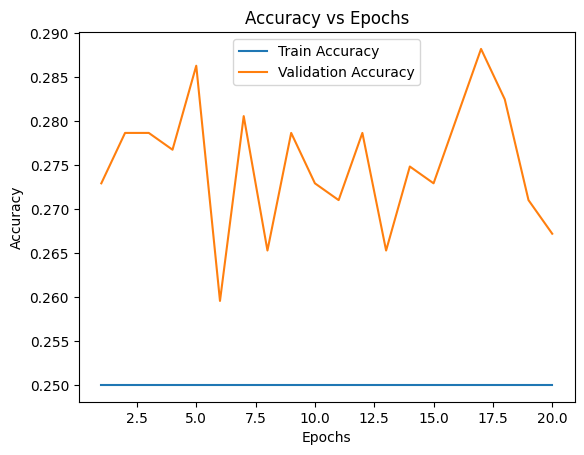

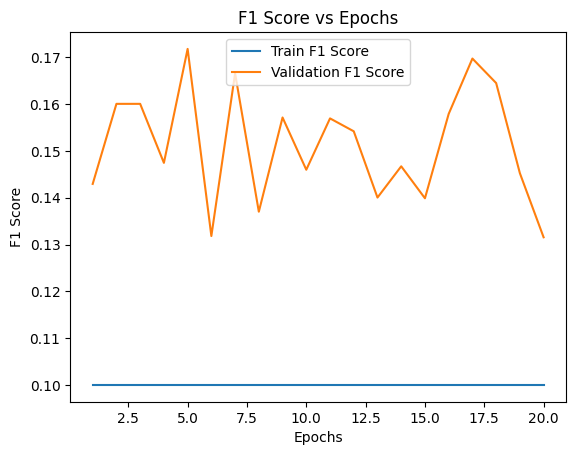

Run 1 => ValAcc: 0.2672, ValF1: 0.1315, ValLoss: 0.7393

===== RUN 2/3 (Percentage=0.1%) =====


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.66it/s]


Epoch [1/30]:
  Train Loss: 0.7484, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7562, Accuracy: 0.2290, F1: 0.1054
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.98it/s]


Epoch [2/30]:
  Train Loss: 0.8068, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7507, Accuracy: 0.2462, F1: 0.1083
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.31it/s]


Epoch [3/30]:
  Train Loss: 0.7368, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7540, Accuracy: 0.2519, F1: 0.1166
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.78it/s]


Epoch [4/30]:
  Train Loss: 0.7817, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7544, Accuracy: 0.2538, F1: 0.1266
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.63it/s]


Epoch [5/30]:
  Train Loss: 0.7566, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7566, Accuracy: 0.2366, F1: 0.1112
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.43it/s]


Epoch [6/30]:
  Train Loss: 0.7692, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7514, Accuracy: 0.2481, F1: 0.1245
No improvement in validation loss for 4 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.01it/s]

Epoch [7/30]:
  Train Loss: 0.7898, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7569, Accuracy: 0.2481, F1: 0.1215
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 0.7898
Final Train Accuracy: 0.2500
Final Train F1: 0.1000
Final Val Loss: 0.7569
Final Val Accuracy: 0.2481
Final Val F1: 0.1215


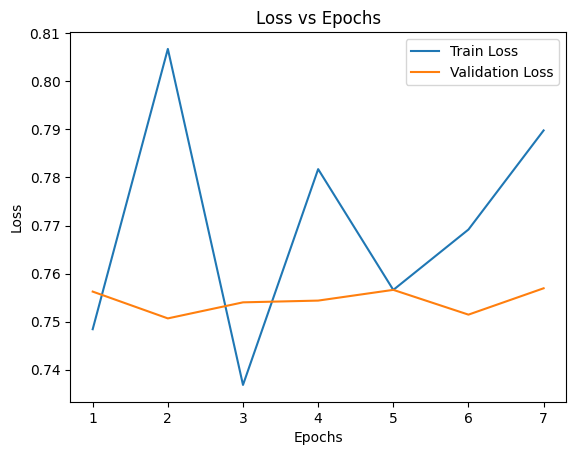

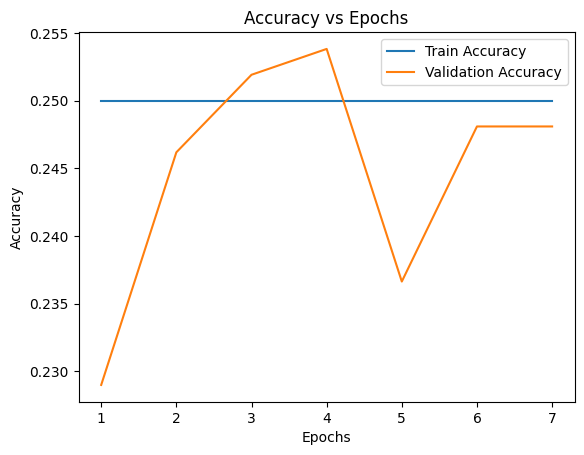

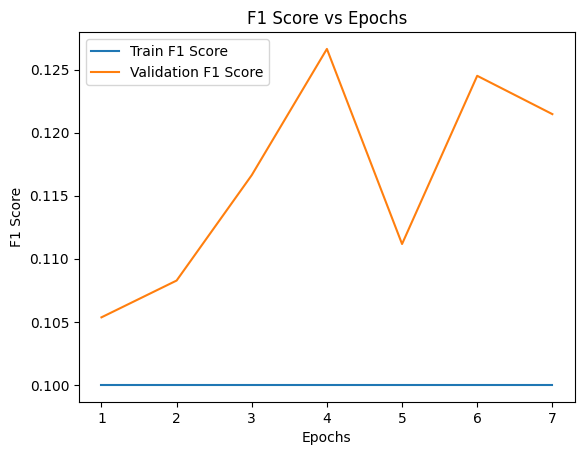

Run 2 => ValAcc: 0.2481, ValF1: 0.1215, ValLoss: 0.7569

===== RUN 3/3 (Percentage=0.1%) =====


Validating: 100%|██████████| 17/17 [00:01<00:00,  9.56it/s]


Epoch [1/30]:
  Train Loss: 0.7809, Accuracy: 0.0000, F1: 0.0000
  Val Loss: 0.7349, Accuracy: 0.2786, F1: 0.1795
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00,  9.93it/s]


Epoch [2/30]:
  Train Loss: 0.7606, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7260, Accuracy: 0.3111, F1: 0.2368
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.61it/s]


Epoch [3/30]:
  Train Loss: 0.7396, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7305, Accuracy: 0.3034, F1: 0.2284
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.30it/s]


Epoch [4/30]:
  Train Loss: 0.7031, Accuracy: 0.5000, F1: 0.5000
  Val Loss: 0.7294, Accuracy: 0.3187, F1: 0.2453
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.53it/s]


Epoch [5/30]:
  Train Loss: 0.7479, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7321, Accuracy: 0.2958, F1: 0.2054
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.67it/s]


Epoch [6/30]:
  Train Loss: 0.7482, Accuracy: 0.2500, F1: 0.1000
  Val Loss: 0.7302, Accuracy: 0.3168, F1: 0.2374
No improvement in validation loss for 4 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.55it/s]

Epoch [7/30]:
  Train Loss: 0.7183, Accuracy: 0.5000, F1: 0.5000
  Val Loss: 0.7287, Accuracy: 0.3168, F1: 0.2351
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 0.7183
Final Train Accuracy: 0.5000
Final Train F1: 0.5000
Final Val Loss: 0.7287
Final Val Accuracy: 0.3168
Final Val F1: 0.2351


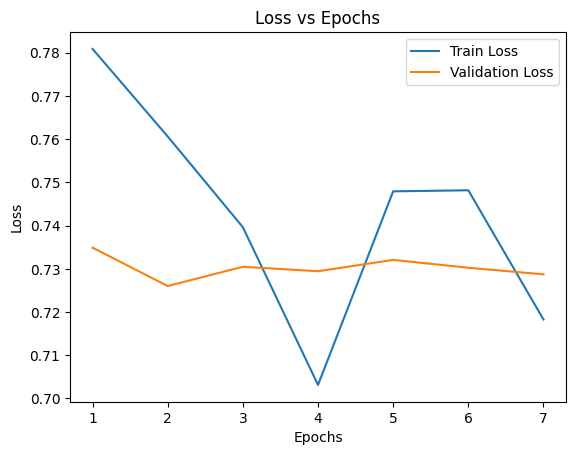

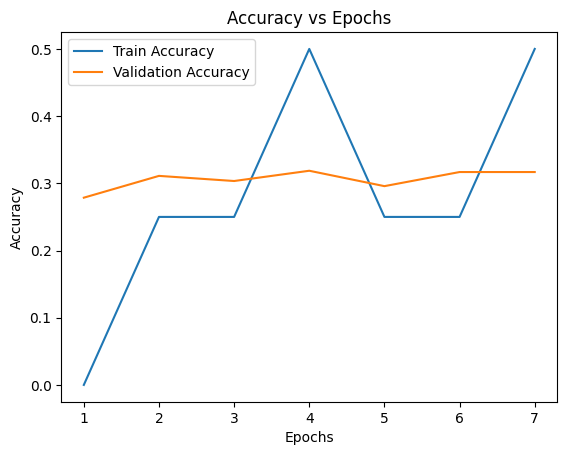

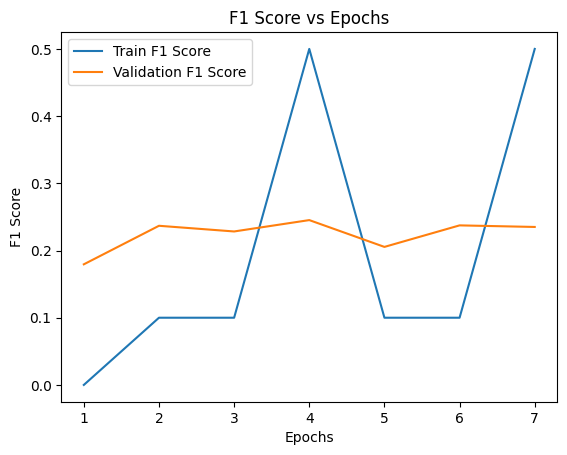

Run 3 => ValAcc: 0.3168, ValF1: 0.2351, ValLoss: 0.7287

===== SUMMARY OVER MULTIPLE RUNS =====
Validation Loss: 0.7416 ± 0.0116
Validation Accuracy: 0.2774 ± 0.0290
Validation F1: 0.1627 ± 0.0513

 Final Val Accuracy = 0.2774 ± 0.0290


In [91]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    percentage = 0.1
    embeddings_file = "/home/dime/Desktop/Pre-thesis/vgg_propagated_embeddings.pth"

    results = train_subset_model_multiple_runs(
        device=device,
        num_runs=3,
        percentage=percentage,
        num_epochs=30,
        lr=0.001,
        patience=5,
        accumulation_steps=4,
        seed=42,
        embeddings_path=embeddings_file
    )

    print(f"\n Final Val Accuracy = {results['val_acc_mean']:.4f} ± {results['val_acc_std']:.4f}")


## EP 1%

EP subset => Using KMeans with n_clusters=47, i.e. ~1% of data.
Selected 47 representatives out of 4708 total.

===== RUN 1/3 (Percentage=1%) =====


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.38it/s]


Epoch [1/30]:
  Train Loss: 0.7365, Accuracy: 0.2979, F1: 0.1367
  Val Loss: 0.7396, Accuracy: 0.2805, F1: 0.1608
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.57it/s]


Epoch [2/30]:
  Train Loss: 0.7053, Accuracy: 0.3191, F1: 0.2115
  Val Loss: 0.7407, Accuracy: 0.2786, F1: 0.1512
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.59it/s]


Epoch [3/30]:
  Train Loss: 0.7282, Accuracy: 0.3191, F1: 0.1803
  Val Loss: 0.7413, Accuracy: 0.2824, F1: 0.1674
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.04it/s]


Epoch [4/30]:
  Train Loss: 0.7130, Accuracy: 0.2979, F1: 0.1367
  Val Loss: 0.7429, Accuracy: 0.2786, F1: 0.1542
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.23it/s]


Epoch [5/30]:
  Train Loss: 0.7163, Accuracy: 0.3191, F1: 0.1803
  Val Loss: 0.7365, Accuracy: 0.2767, F1: 0.1564
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.12it/s]


Epoch [6/30]:
  Train Loss: 0.7122, Accuracy: 0.3404, F1: 0.2216
  Val Loss: 0.7378, Accuracy: 0.2691, F1: 0.1475
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.06it/s]


Epoch [7/30]:
  Train Loss: 0.7401, Accuracy: 0.3191, F1: 0.1803
  Val Loss: 0.7418, Accuracy: 0.2805, F1: 0.1637
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.38it/s]


Epoch [8/30]:
  Train Loss: 0.7057, Accuracy: 0.3191, F1: 0.1803
  Val Loss: 0.7430, Accuracy: 0.2691, F1: 0.1415
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.22it/s]


Epoch [9/30]:
  Train Loss: 0.7185, Accuracy: 0.3191, F1: 0.2115
  Val Loss: 0.7439, Accuracy: 0.2672, F1: 0.1438
No improvement in validation loss for 4 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.27it/s]

Epoch [10/30]:
  Train Loss: 0.7331, Accuracy: 0.3404, F1: 0.2216
  Val Loss: 0.7443, Accuracy: 0.2748, F1: 0.1614
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 0.7331
Final Train Accuracy: 0.3404
Final Train F1: 0.2216
Final Val Loss: 0.7443
Final Val Accuracy: 0.2748
Final Val F1: 0.1614


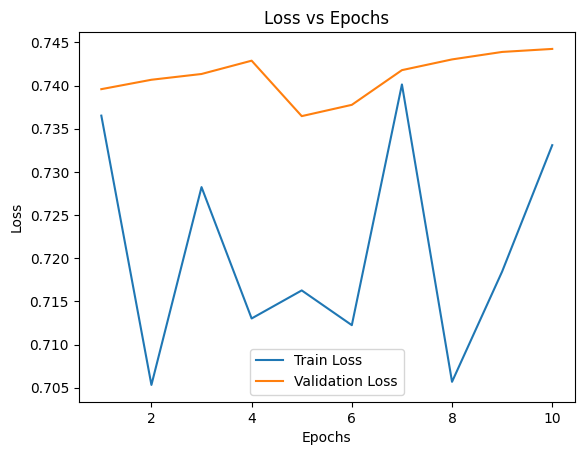

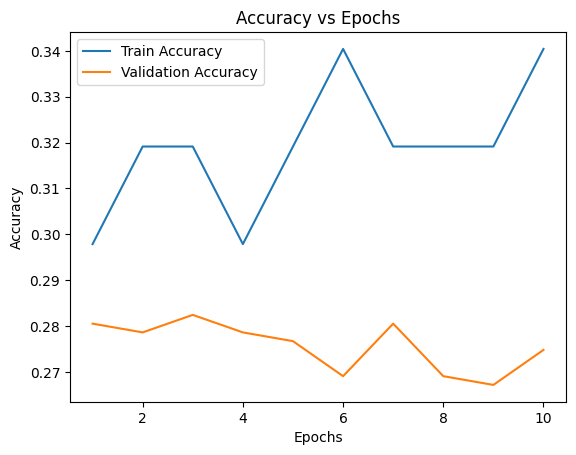

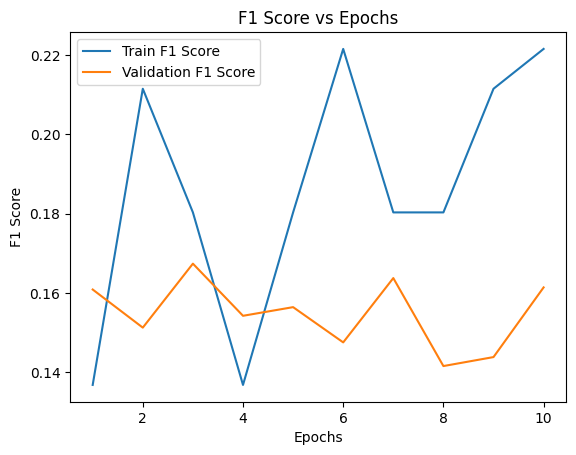

Run 1 => ValAcc: 0.2748, ValF1: 0.1614, ValLoss: 0.7443

===== RUN 2/3 (Percentage=1%) =====


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.80it/s]


Epoch [1/30]:
  Train Loss: 0.7616, Accuracy: 0.2553, F1: 0.1212
  Val Loss: 0.7537, Accuracy: 0.2481, F1: 0.1153
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.63it/s]


Epoch [2/30]:
  Train Loss: 0.7479, Accuracy: 0.2766, F1: 0.1291
  Val Loss: 0.7524, Accuracy: 0.2424, F1: 0.1070
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.18it/s]


Epoch [3/30]:
  Train Loss: 0.7448, Accuracy: 0.2128, F1: 0.1045
  Val Loss: 0.7541, Accuracy: 0.2424, F1: 0.1101
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.31it/s]


Epoch [4/30]:
  Train Loss: 0.7492, Accuracy: 0.2553, F1: 0.1212
  Val Loss: 0.7569, Accuracy: 0.2443, F1: 0.1170
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.71it/s]


Epoch [5/30]:
  Train Loss: 0.7613, Accuracy: 0.2766, F1: 0.1291
  Val Loss: 0.7460, Accuracy: 0.2462, F1: 0.1177
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.25it/s]


Epoch [6/30]:
  Train Loss: 0.7452, Accuracy: 0.2553, F1: 0.1212
  Val Loss: 0.7529, Accuracy: 0.2500, F1: 0.1160
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.15it/s]


Epoch [7/30]:
  Train Loss: 0.7323, Accuracy: 0.2979, F1: 0.1367
  Val Loss: 0.7540, Accuracy: 0.2500, F1: 0.1282
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.50it/s]


Epoch [8/30]:
  Train Loss: 0.7458, Accuracy: 0.2553, F1: 0.1212
  Val Loss: 0.7537, Accuracy: 0.2366, F1: 0.1050
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.56it/s]


Epoch [9/30]:
  Train Loss: 0.7446, Accuracy: 0.2766, F1: 0.1291
  Val Loss: 0.7566, Accuracy: 0.2443, F1: 0.1076
No improvement in validation loss for 4 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.28it/s]

Epoch [10/30]:
  Train Loss: 0.7605, Accuracy: 0.2340, F1: 0.1130
  Val Loss: 0.7504, Accuracy: 0.2519, F1: 0.1135
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 0.7605
Final Train Accuracy: 0.2340
Final Train F1: 0.1130
Final Val Loss: 0.7504
Final Val Accuracy: 0.2519
Final Val F1: 0.1135


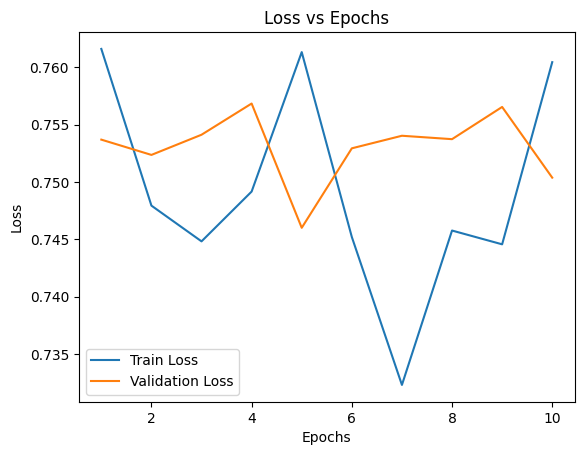

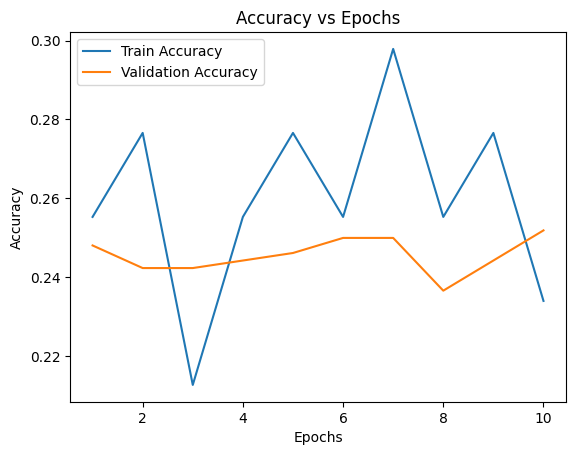

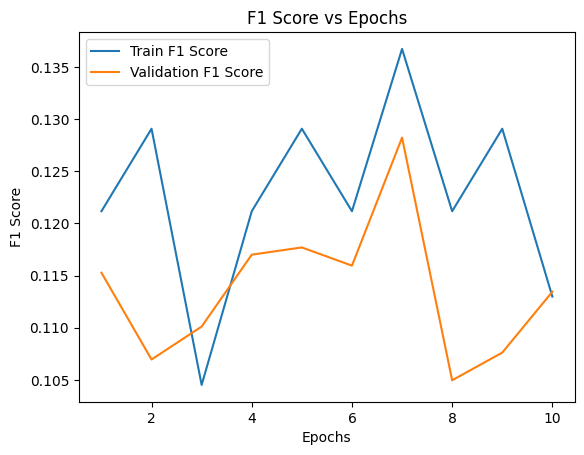

Run 2 => ValAcc: 0.2519, ValF1: 0.1135, ValLoss: 0.7504

===== RUN 3/3 (Percentage=1%) =====


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.74it/s]


Epoch [1/30]:
  Train Loss: 0.7136, Accuracy: 0.3617, F1: 0.2608
  Val Loss: 0.7351, Accuracy: 0.2824, F1: 0.1916
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00,  9.99it/s]


Epoch [2/30]:
  Train Loss: 0.7000, Accuracy: 0.3404, F1: 0.2497
  Val Loss: 0.7286, Accuracy: 0.2958, F1: 0.2222
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.01it/s]


Epoch [3/30]:
  Train Loss: 0.7414, Accuracy: 0.3191, F1: 0.1803
  Val Loss: 0.7329, Accuracy: 0.2958, F1: 0.2176
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.32it/s]


Epoch [4/30]:
  Train Loss: 0.7165, Accuracy: 0.3191, F1: 0.2385
  Val Loss: 0.7316, Accuracy: 0.2920, F1: 0.2109
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.98it/s]


Epoch [5/30]:
  Train Loss: 0.7357, Accuracy: 0.2766, F1: 0.1291
  Val Loss: 0.7316, Accuracy: 0.2920, F1: 0.1985
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.06it/s]


Epoch [6/30]:
  Train Loss: 0.7248, Accuracy: 0.3617, F1: 0.2861
  Val Loss: 0.7319, Accuracy: 0.3015, F1: 0.2180
No improvement in validation loss for 4 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.04it/s]

Epoch [7/30]:
  Train Loss: 0.7278, Accuracy: 0.2979, F1: 0.2013
  Val Loss: 0.7293, Accuracy: 0.3073, F1: 0.2303
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 0.7278
Final Train Accuracy: 0.2979
Final Train F1: 0.2013
Final Val Loss: 0.7293
Final Val Accuracy: 0.3073
Final Val F1: 0.2303


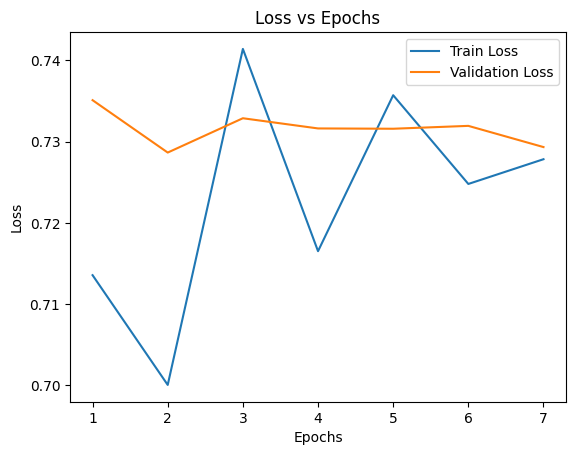

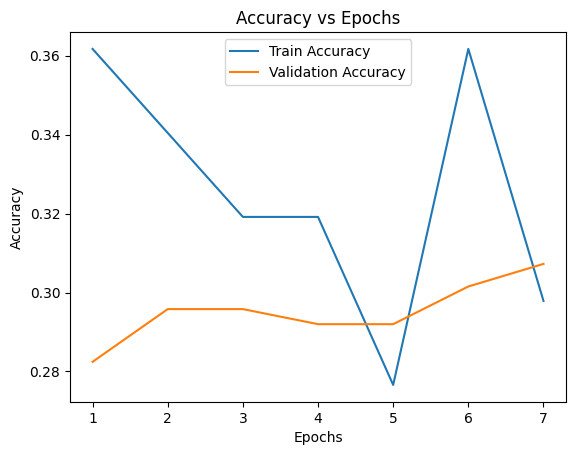

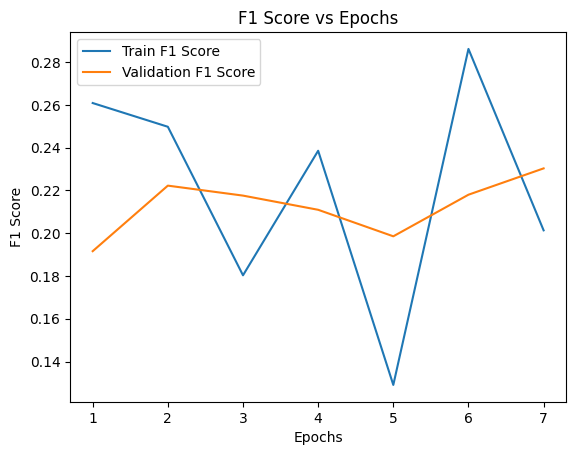

Run 3 => ValAcc: 0.3073, ValF1: 0.2303, ValLoss: 0.7293

===== SUMMARY OVER MULTIPLE RUNS =====
Validation Loss: 0.7413 ± 0.0088
Validation Accuracy: 0.2780 ± 0.0227
Validation F1: 0.1684 ± 0.0480

 Final Val Accuracy = 0.2780 ± 0.0227


In [92]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    percentage = 1
    embeddings_file = "/home/dime/Desktop/Pre-thesis/vgg_propagated_embeddings.pth"

    results = train_subset_model_multiple_runs(
        device=device,
        num_runs=3,
        percentage=percentage,
        num_epochs=30,
        lr=0.001,
        patience=5,
        accumulation_steps=4,
        seed=42,
        embeddings_path=embeddings_file
    )

    print(f"\n Final Val Accuracy = {results['val_acc_mean']:.4f} ± {results['val_acc_std']:.4f}")

## EP 10%

EP subset => Using KMeans with n_clusters=470, i.e. ~10% of data.
Selected 470 representatives out of 4708 total.

===== RUN 1/3 (Percentage=10%) =====


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.65it/s]


Epoch [1/30]:
  Train Loss: 0.6231, Accuracy: 0.6277, F1: 0.6314
  Val Loss: 0.5443, Accuracy: 0.7805, F1: 0.7439
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.14it/s]


Epoch [2/30]:
  Train Loss: 0.5989, Accuracy: 0.7128, F1: 0.6826
  Val Loss: 0.4998, Accuracy: 0.7786, F1: 0.7331
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.05it/s]


Epoch [3/30]:
  Train Loss: 0.5508, Accuracy: 0.7426, F1: 0.7183
  Val Loss: 0.4879, Accuracy: 0.8034, F1: 0.7693
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.40it/s]


Epoch [4/30]:
  Train Loss: 0.5294, Accuracy: 0.7617, F1: 0.7429
  Val Loss: 0.5464, Accuracy: 0.7805, F1: 0.7480
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.08it/s]


Epoch [5/30]:
  Train Loss: 0.5499, Accuracy: 0.7383, F1: 0.7146
  Val Loss: 0.5181, Accuracy: 0.7920, F1: 0.7530
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.81it/s]


Epoch [6/30]:
  Train Loss: 0.5541, Accuracy: 0.7298, F1: 0.6982
  Val Loss: 0.5235, Accuracy: 0.7863, F1: 0.7454
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.87it/s]


Epoch [7/30]:
  Train Loss: 0.5940, Accuracy: 0.7319, F1: 0.7043
  Val Loss: 0.4965, Accuracy: 0.7824, F1: 0.7252
No improvement in validation loss for 4 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.16it/s]

Epoch [8/30]:
  Train Loss: 0.5805, Accuracy: 0.7489, F1: 0.7191
  Val Loss: 0.5109, Accuracy: 0.7882, F1: 0.7438
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 0.5805
Final Train Accuracy: 0.7489
Final Train F1: 0.7191
Final Val Loss: 0.5109
Final Val Accuracy: 0.7882
Final Val F1: 0.7438


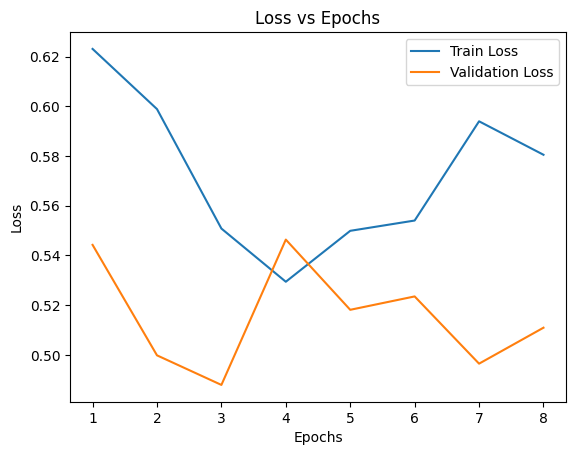

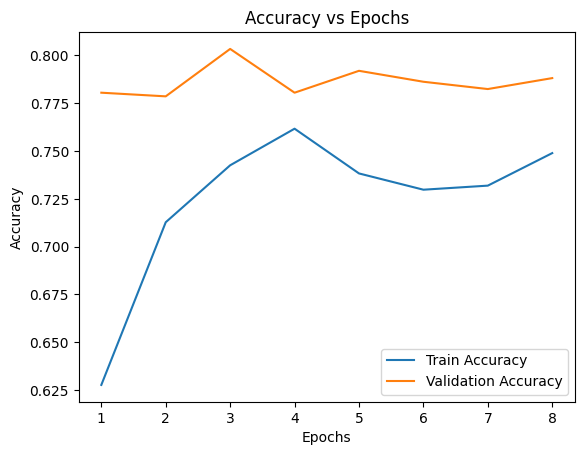

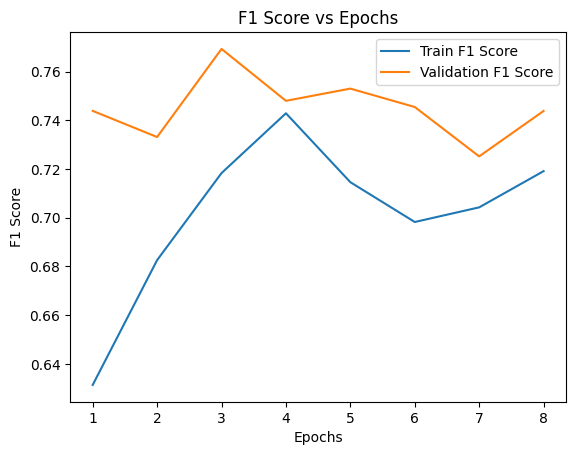

Run 1 => ValAcc: 0.7882, ValF1: 0.7438, ValLoss: 0.5109

===== RUN 2/3 (Percentage=10%) =====


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.43it/s]


Epoch [1/30]:
  Train Loss: 0.6825, Accuracy: 0.5447, F1: 0.5344
  Val Loss: 0.5315, Accuracy: 0.7653, F1: 0.6909
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.59it/s]


Epoch [2/30]:
  Train Loss: 0.6375, Accuracy: 0.6957, F1: 0.6367
  Val Loss: 0.5123, Accuracy: 0.7824, F1: 0.7344
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00,  9.89it/s]


Epoch [3/30]:
  Train Loss: 0.5808, Accuracy: 0.7277, F1: 0.6975
  Val Loss: 0.5262, Accuracy: 0.7805, F1: 0.7424
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00,  9.78it/s]


Epoch [4/30]:
  Train Loss: 0.5716, Accuracy: 0.7340, F1: 0.7143
  Val Loss: 0.5296, Accuracy: 0.7824, F1: 0.7424
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.79it/s]


Epoch [5/30]:
  Train Loss: 0.5868, Accuracy: 0.6957, F1: 0.6682
  Val Loss: 0.5046, Accuracy: 0.7882, F1: 0.7499
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.58it/s]


Epoch [6/30]:
  Train Loss: 0.5453, Accuracy: 0.7383, F1: 0.7098
  Val Loss: 0.5092, Accuracy: 0.7863, F1: 0.7390
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.25it/s]


Epoch [7/30]:
  Train Loss: 0.5520, Accuracy: 0.7298, F1: 0.6913
  Val Loss: 0.4921, Accuracy: 0.7996, F1: 0.7577
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.13it/s]


Epoch [8/30]:
  Train Loss: 0.5530, Accuracy: 0.7277, F1: 0.6953
  Val Loss: 0.5092, Accuracy: 0.7786, F1: 0.7394
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.05it/s]


Epoch [9/30]:
  Train Loss: 0.5530, Accuracy: 0.7383, F1: 0.7108
  Val Loss: 0.5375, Accuracy: 0.7977, F1: 0.7671
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00,  9.88it/s]


Epoch [10/30]:
  Train Loss: 0.5531, Accuracy: 0.7681, F1: 0.7501
  Val Loss: 0.5356, Accuracy: 0.8053, F1: 0.7782
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.81it/s]


Epoch [11/30]:
  Train Loss: 0.5429, Accuracy: 0.7532, F1: 0.7286
  Val Loss: 0.5376, Accuracy: 0.7920, F1: 0.7530
No improvement in validation loss for 4 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.16it/s]

Epoch [12/30]:
  Train Loss: 0.5326, Accuracy: 0.7426, F1: 0.7155
  Val Loss: 0.5313, Accuracy: 0.7653, F1: 0.7196
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 0.5326
Final Train Accuracy: 0.7426
Final Train F1: 0.7155
Final Val Loss: 0.5313
Final Val Accuracy: 0.7653
Final Val F1: 0.7196


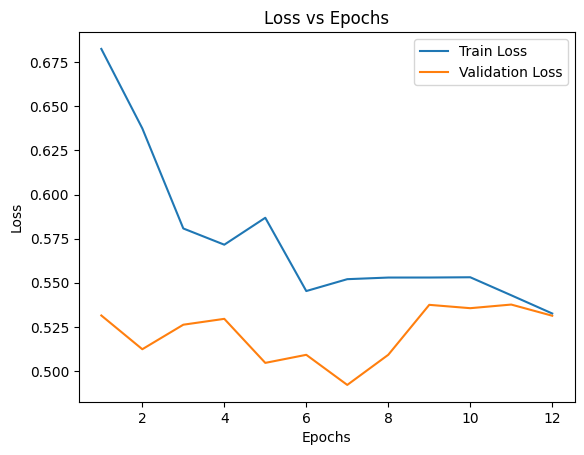

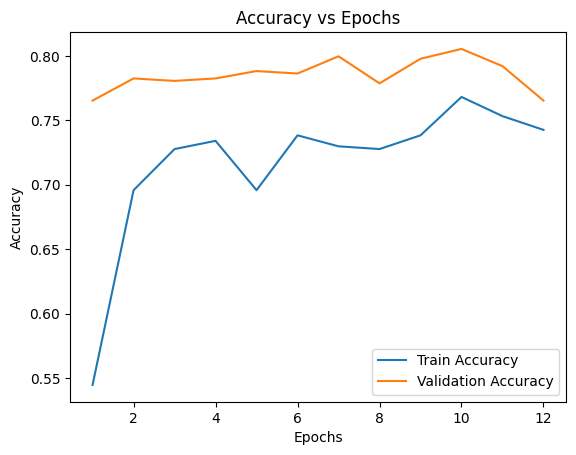

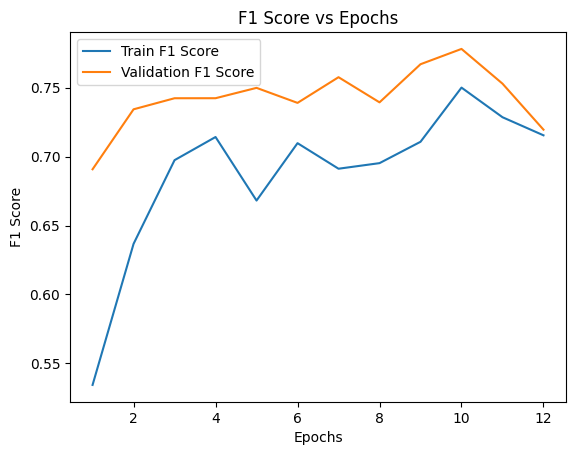

Run 2 => ValAcc: 0.7653, ValF1: 0.7196, ValLoss: 0.5313

===== RUN 3/3 (Percentage=10%) =====


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.07it/s]


Epoch [1/30]:
  Train Loss: 0.6534, Accuracy: 0.5660, F1: 0.5440
  Val Loss: 0.5329, Accuracy: 0.7615, F1: 0.6833
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.83it/s]


Epoch [2/30]:
  Train Loss: 0.6052, Accuracy: 0.6936, F1: 0.6333
  Val Loss: 0.5192, Accuracy: 0.7901, F1: 0.7403
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00,  9.60it/s]


Epoch [3/30]:
  Train Loss: 0.5698, Accuracy: 0.7277, F1: 0.7025
  Val Loss: 0.5575, Accuracy: 0.7901, F1: 0.7583
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.41it/s]


Epoch [4/30]:
  Train Loss: 0.5618, Accuracy: 0.7191, F1: 0.6978
  Val Loss: 0.5294, Accuracy: 0.8015, F1: 0.7772
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.43it/s]


Epoch [5/30]:
  Train Loss: 0.5857, Accuracy: 0.7170, F1: 0.6873
  Val Loss: 0.4937, Accuracy: 0.8015, F1: 0.7715
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.10it/s]


Epoch [6/30]:
  Train Loss: 0.5510, Accuracy: 0.7383, F1: 0.7108
  Val Loss: 0.4841, Accuracy: 0.7977, F1: 0.7561
Validation loss improved. Model saved.


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.17it/s]


Epoch [7/30]:
  Train Loss: 0.5811, Accuracy: 0.7277, F1: 0.7006
  Val Loss: 0.5125, Accuracy: 0.7996, F1: 0.7661
No improvement in validation loss for 1 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.10it/s]


Epoch [8/30]:
  Train Loss: 0.5729, Accuracy: 0.7255, F1: 0.7034
  Val Loss: 0.5508, Accuracy: 0.7863, F1: 0.7634
No improvement in validation loss for 2 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.78it/s]


Epoch [9/30]:
  Train Loss: 0.5310, Accuracy: 0.7468, F1: 0.7317
  Val Loss: 0.5510, Accuracy: 0.7824, F1: 0.7495
No improvement in validation loss for 3 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 10.83it/s]


Epoch [10/30]:
  Train Loss: 0.5318, Accuracy: 0.7532, F1: 0.7374
  Val Loss: 0.5118, Accuracy: 0.7920, F1: 0.7659
No improvement in validation loss for 4 epoch(s).


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.69it/s]

Epoch [11/30]:
  Train Loss: 0.5457, Accuracy: 0.7362, F1: 0.7099
  Val Loss: 0.4957, Accuracy: 0.7882, F1: 0.7541
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 0.5457
Final Train Accuracy: 0.7362
Final Train F1: 0.7099
Final Val Loss: 0.4957
Final Val Accuracy: 0.7882
Final Val F1: 0.7541


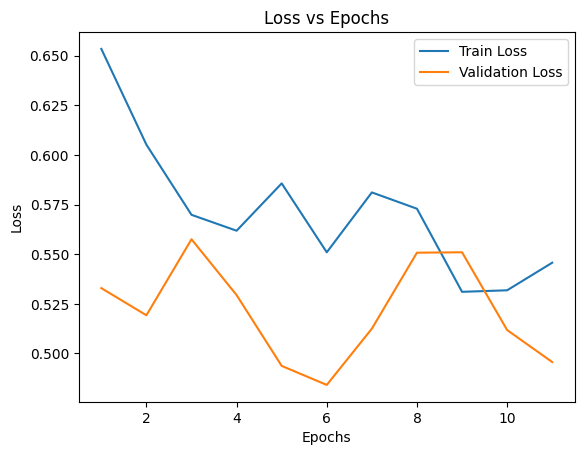

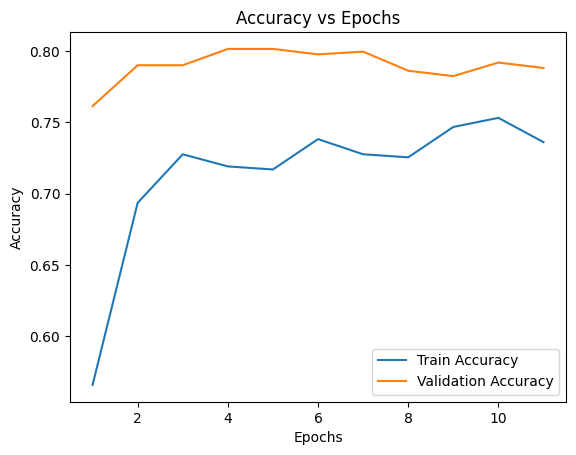

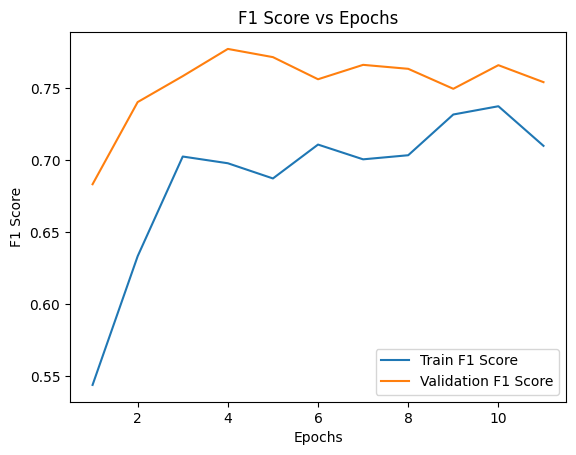

Run 3 => ValAcc: 0.7882, ValF1: 0.7541, ValLoss: 0.4957

===== SUMMARY OVER MULTIPLE RUNS =====
Validation Loss: 0.5126 ± 0.0146
Validation Accuracy: 0.7805 ± 0.0108
Validation F1: 0.7392 ± 0.0145

 Final Val Accuracy = 0.7805 ± 0.0108


In [93]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    percentage = 10
    embeddings_file = "/home/dime/Desktop/Pre-thesis/vgg_propagated_embeddings.pth"

    results = train_subset_model_multiple_runs(
        device=device,
        num_runs=3,
        percentage=percentage,
        num_epochs=30,
        lr=0.001,
        patience=5,
        accumulation_steps=4,
        seed=42,
        embeddings_path=embeddings_file
    )

    print(f"\n Final Val Accuracy = {results['val_acc_mean']:.4f} ± {results['val_acc_std']:.4f}")